# Generate a Mock Dataset

Generate a simulated TF dataset as follows:

* Merge the iron photometric + spectroscopic catalogs with the SGA2020 catalog.
* Apply all photometric corrections used in the TF analysis.
* Cross-match with one of the BGS mocks.
* Apply photometric and morphological cuts used in the PV survey for late-type galaxies.
* Generate mock rotational velocities by sampling from the data.
* Generate mock TFR distances.

Here, we fit the TFR in bins of $z$ (as our "clusters").

In [23]:
import os
import shutil
import h5py
import pickle
import pandas as pd
import numpy as np

from itertools import groupby

from csaps import csaps
from scipy.stats import binned_statistic
from scipy.odr import ODR, Model, RealData
from scipy.spatial import KDTree

#- Global file path for PV analysis.
#  Set to the NERSC folder /global/cfs/cdirs/desi/science/td/pv by default.
#  Set it to something else if working offline.
pvpath = '/global/cfs/cdirs/desi/science/td/pv'
mockpath = os.path.join(pvpath, 'mocks')
tfmockpath = os.path.join(mockpath, 'TF_mocks')

from corner import corner

#- Path to TF_mocks: code for Blanton's k-corrections.
import sys
sys.path.append(tfmockpath)
import TF_photoCorrect as tfpc

sys.path.append('/global/u1/k/kadglass/DESI_SGA/TF/')
from hyperfit.linfit import LinFit
from hyperfit_v2 import MultiLinFit
from line_fits import hyperfit_line_multi
from help_functions import profile_histogram

from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import Planck18, FlatLambdaCDM, units
from astropy.coordinates import SkyCoord, Distance

from tqdm import tqdm
from glob import glob

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
LightSpeed = const.c.to('km/s').value

## Iron Data + SGA Catalog

Follow the procedure used in FP mock generation: read in iron data relevant for the TFR for cross-matching to the BGS mocks, producing a simulated set with realistic galaxy observables.

Here we merge the fullsweep and iron specprod catalogs to reproduce cuts when cross-matching with the mocks.

As a final step, get any missing SGA data directly from the SGA 2020 catalog.

In [3]:
#- Read in the iron fullsweep and specprod catalogs.
sw_keys = ['targetid', 'survey', 'program', 'healpix', 'target_ra', 'target_dec',
           'z', 'zerr', 'zwarn', 'inbasiccuts', 'has_corrupt_phot',
           'mag_g', 'mag_r', 'mag_z',
           'morphtype', 'sersic', 'BA_ratio',
           'circ_radius', 'circ_radius_err', 'uncor_radius', 'SGA_id', 'radius_SB25']

ironsweep = os.path.join(pvpath, 'redshift_data/Y1/iron_fullsweep_catalogue_z012.csv')
iron = pd.read_csv(ironsweep, usecols=sw_keys)

#- Read in the spectroscopic production table generated by Caitlin Ross.
sp_keys = ['targetid', 'survey', 'program', 'healpix',
           'mag_err_g', 'mag_err_r', 'mag_err_z', 
           'deltachi2']

ironspec = os.path.join(pvpath, 'redshift_data/Y1/specprod_iron_healpix_z015.csv')
ironsp = pd.read_csv(ironspec, usecols=sp_keys)

#- Cross-match the catalogs.
iron = pd.merge(iron, ironsp, 
                left_on=['targetid', 'survey', 'program', 'healpix'],
                right_on=['targetid', 'survey', 'program', 'healpix'], how='inner')

#- Object selection from the spectro pipeline:
#  1. Valid SGA ID, which implicitly enforces a size selection.
#  2. Delta-chi2 > 25.
#  3. No redrock warnings.
select = (iron['SGA_id'] > 0) & \
         (iron['deltachi2'] >= 25) & \
         (iron['zwarn'] == 0)

iron = iron.drop(iron[~select].index)

#- Read the SGA catalog and match on SGA_ID.
#  This is needed to access R_26 and other quantities at the mag 26 isophote.
sgafile = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'
sgacat = Table.read(sgafile, 'ELLIPSE')
sgacat.rename_column('SGA_ID', 'SGA_id')
sgacat.rename_column('RA', 'SGA_ra')
sgacat.rename_column('DEC', 'SGA_dec')
sgacat = sgacat['SGA_ra', 'SGA_dec', 'SGA_id', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR', 'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR'].to_pandas()
sgacat = sgacat.drop(sgacat[sgacat['R_MAG_SB26'] < 0].index)

iron = pd.merge(iron, sgacat, how='inner', on=['SGA_id'])

In [4]:
#- Drop NaN
iron = iron.dropna()
iron

survey program  healpix           targetid  target_dec   target_ra  \
0         sv1  bright    34723  39627082556248187  -30.586432   58.890261   
1         sv1  bright    34725  39627082589804885  -30.509964   61.244826   
2         sv1  bright    34703  39627082593998226  -30.408004   61.518464   
3         sv1  bright    34729  39627087765574578  -30.251105   58.278362   
4         sv1  bright    34729  39627087773962063  -30.188369   58.780902   
...       ...     ...      ...                ...         ...         ...   
102514   main    dark     7975   2852649649045504   72.895711  131.867353   
102515   main    dark     7973   2852649653239808   72.926464  133.218536   
102516   main    dark     8034   2852673590132736   76.634771  140.593982   
102517    sv3  bright    11604  39633456283519525   66.170195  266.658931   
102518    sv3    dark    11604  39633456283519525   66.170195  266.658931   

               z          zerr  zwarn morphtype  ...  mag_err_r      SGA_ra  \
0       0.093327  1.755050e-05      0       SER  ...   0.000430   58.890261   
1       0.058229  3.289745e-06      0       SER  ...   0.000833   61.244826   
2       0.059050  2.278493e-06      0       SER  ...   0.000355   61.518464   
3       0.081022  1.363088e-05      0       SER  ...   0.001176   58.278362   
4       0.096937  1.941603e-05      0       SER  ...   0.000785   58.780902   
...          ...           ...    ...       ...  ...        ...         ...   
102514  0.011291  7.328162e-06      0       DEV  ...   0.000785  131.867353   
102515  0.012603  7.566643e-07      0       DEV  ...   0.000462  133.218536   
102516  0.076971  4.815062e-06      0       SER  ...   0.001131  140.593982   
102517  0.117068  1.531648e-05      0       SER  ...   0.001742  266.658931   
102518  0.117098  8.208770e-06      0       SER  ...   0.001742  266.658931   

          SGA_dec       D26  G_MAG_SB26  G_MAG_SB26_ERR  R_MAG_SB26  \
0      -30.586432  0.575315   17.063408        0.034668   16.134380   
1      -30.509964  0.398020   17.159575        0.005541   16.691721   
2      -30.408004  0.998481   16.092411        0.024773   15.328482   
3      -30.251105  0.427528   18.176348        0.028036   17.460354   
4      -30.188369  0.648811   17.540487        0.039971   16.529564   
...           ...       ...         ...             ...         ...   
102514  72.895711  0.841495   16.188450        0.005690   15.252360   
102515  72.926464  1.141312   15.233910        0.016896   14.147840   
102516  76.634771  0.515602   16.521830        0.005591   15.891319   
102517  66.170195  0.686332   16.746572        0.019684   16.290340   
102518  66.170195  0.686332   16.746572        0.019684   16.290340   

        R_MAG_SB26_ERR  Z_MAG_SB26  Z_MAG_SB26_ERR  
0             0.038069   15.478448        0.039409  
1             0.005926   16.403215        0.006768  
2             0.026500   14.777832        0.026026  
3             0.029271   16.949606        0.031180  
4             0.041773   15.713690        0.042567  
...                ...         ...             ...  
102514        0.006012   14.736343        0.008489  
102515        0.015995   13.483636        0.021117  
102516        0.005790   15.526414        0.006989  
102517        0.016576   16.699310        0.030471  
102518        0.016576   16.699310        0.030471  

[93971 rows x 35 columns]

### Keep only Galaxy Centers

The iron catalog may include some off-axis measurements of SGA galaxies that pass the spectroscopic cuts. Remove them with a cone-angle cut, comparing the SGA centers (from Tractor) to the target RA, Dec in DESI. The cut is

$$
\frac{\angle(\mathbf{r}_\mathrm{SGA}, \mathbf{r}_\mathrm{fiber})}{D_{26}/2} < 0.1
$$

See details in Kelly's [SGA selection notebook for iron](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/iron_rot_vel.ipynb).

Note that requiring a nonzero $m_{r,\mathrm{SB_{26}}}$ may remove all spectra not measured on galaxy centers, making this cut redundant.

In [5]:
coords_sga = SkyCoord(ra=iron['SGA_ra'], dec=iron['SGA_dec'], unit='degree')
coords_iron = SkyCoord(ra=iron['target_ra'], dec=iron['target_dec'], unit='degree')
sep2d = coords_iron.separation(coords_sga)
select = (2*sep2d.to_value('arcmin') / iron['D26']) < 0.1

iron = iron.drop(iron[~select].index)

In [6]:
iron

survey program  healpix           targetid  target_dec   target_ra  \
0         sv1  bright    34723  39627082556248187  -30.586432   58.890261   
1         sv1  bright    34725  39627082589804885  -30.509964   61.244826   
2         sv1  bright    34703  39627082593998226  -30.408004   61.518464   
3         sv1  bright    34729  39627087765574578  -30.251105   58.278362   
4         sv1  bright    34729  39627087773962063  -30.188369   58.780902   
...       ...     ...      ...                ...         ...         ...   
102514   main    dark     7975   2852649649045504   72.895711  131.867353   
102515   main    dark     7973   2852649653239808   72.926464  133.218536   
102516   main    dark     8034   2852673590132736   76.634771  140.593982   
102517    sv3  bright    11604  39633456283519525   66.170195  266.658931   
102518    sv3    dark    11604  39633456283519525   66.170195  266.658931   

               z          zerr  zwarn morphtype  ...  mag_err_r      SGA_ra  \
0       0.093327  1.755050e-05      0       SER  ...   0.000430   58.890261   
1       0.058229  3.289745e-06      0       SER  ...   0.000833   61.244826   
2       0.059050  2.278493e-06      0       SER  ...   0.000355   61.518464   
3       0.081022  1.363088e-05      0       SER  ...   0.001176   58.278362   
4       0.096937  1.941603e-05      0       SER  ...   0.000785   58.780902   
...          ...           ...    ...       ...  ...        ...         ...   
102514  0.011291  7.328162e-06      0       DEV  ...   0.000785  131.867353   
102515  0.012603  7.566643e-07      0       DEV  ...   0.000462  133.218536   
102516  0.076971  4.815062e-06      0       SER  ...   0.001131  140.593982   
102517  0.117068  1.531648e-05      0       SER  ...   0.001742  266.658931   
102518  0.117098  8.208770e-06      0       SER  ...   0.001742  266.658931   

          SGA_dec       D26  G_MAG_SB26  G_MAG_SB26_ERR  R_MAG_SB26  \
0      -30.586432  0.575315   17.063408        0.034668   16.134380   
1      -30.509964  0.398020   17.159575        0.005541   16.691721   
2      -30.408004  0.998481   16.092411        0.024773   15.328482   
3      -30.251105  0.427528   18.176348        0.028036   17.460354   
4      -30.188369  0.648811   17.540487        0.039971   16.529564   
...           ...       ...         ...             ...         ...   
102514  72.895711  0.841495   16.188450        0.005690   15.252360   
102515  72.926464  1.141312   15.233910        0.016896   14.147840   
102516  76.634771  0.515602   16.521830        0.005591   15.891319   
102517  66.170195  0.686332   16.746572        0.019684   16.290340   
102518  66.170195  0.686332   16.746572        0.019684   16.290340   

        R_MAG_SB26_ERR  Z_MAG_SB26  Z_MAG_SB26_ERR  
0             0.038069   15.478448        0.039409  
1             0.005926   16.403215        0.006768  
2             0.026500   14.777832        0.026026  
3             0.029271   16.949606        0.031180  
4             0.041773   15.713690        0.042567  
...                ...         ...             ...  
102514        0.006012   14.736343        0.008489  
102515        0.015995   13.483636        0.021117  
102516        0.005790   15.526414        0.006989  
102517        0.016576   16.699310        0.030471  
102518        0.016576   16.699310        0.030471  

[93971 rows x 35 columns]

## Apply Dust and K-corrections

There are four photometric corrections that need to be applied.

1. N vs. S imaging catalog photometric systematics.
2. $k$-corrections to $z=0.1$.
3. Global Milky Way dust corrections using the maps from Zhou+, 2024.
4. Per-galaxy internal dust corrections based on the galaxies' inclination angles.

The corrections, applied to the $r$-band magnitudes, are summed as

$$
A_\mathrm{sys} + A_k + A_\mathrm{MW} + A_\mathrm{dust}
$$

### Imaging Systematics

In [7]:
#- Apply imaging survey systematics: compute photometric system (N or S)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
c = SkyCoord(iron['target_ra'], iron['target_dec'], unit='degree')
isnorth = (c.galactic.b > 0) & (iron['target_dec'] > 32.375)
iron['photsys'] = 'S'
iron.loc[isnorth, 'photsys'] = 'N'

#- Adjust northern photometry to DECaLS
Asys, Asys_err = tfpc.BASS_corr(iron['photsys'])

### K Correction

In [8]:
#- This is based on the kcorrect package by Blanton (https://kcorrect.readthedocs.io/)
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
select = iron['z'] > 0

kc = tfpc.k_corr(iron['z'][select], 
                [iron['G_MAG_SB26'][select],     iron['R_MAG_SB26'][select],     iron['Z_MAG_SB26'][select]], 
                [iron['G_MAG_SB26_ERR'][select], iron['R_MAG_SB26_ERR'][select], iron['Z_MAG_SB26_ERR'][select]], 
                z_corr=0.1)

Ak = np.zeros((len(iron), 3))
Ak[select] = kc

### MW Dust Correction

In [9]:
#- Compute MW dust corrections
#  Note that we need the RA,Dec of the *data*, not the mocks, because the corrections
#  are applied to the observed magnitudes from SGA (MAG_R_SB26, etc.).
dustmap = '/global/cfs/cdirs/desi/public/papers/mws/desi_dust/y2/v1/maps/desi_dust_gr_512.fits'
ebv = Table.read(dustmap)
Adust, Adust_err = tfpc.MW_dust(iron['target_ra'].values, iron['target_dec'].values, ebv)

#- Mask out NaNs
for i, band in enumerate('grz'):
    isnan_gal = np.isnan(Adust[i])
    if np.any(isnan_gal):
        logging.info(f'Removing NaN for MW dust correction, band {band}')
        Adust[i][isnan_gal] = 0
        Adust_err[i][isnan_gal] = 0

/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


### Apply MW, K-Correction, and Imaging Systematics Corrections Prior to Internal Dust Correction

In [10]:
#- Apply MW dust, k-corrections, and photometric systematic corrections to the data.
for i, band in enumerate('GRZ'):
    iron[f'{band}_MAG_SB26_tmp'] = iron[f'{band}_MAG_SB26'] - Adust[i] + Asys + Ak[:,i]
    iron[f'{band}_MAG_SB26_ERR_tmp'] = np.sqrt(iron[f'{band}_MAG_SB26_ERR']**2 + Adust_err[i]**2 + Asys_err**2)

### Internal Dust Correction 

Correct m_r for the internal galactic dust, assuming that as we look through higher inclinations we're viewing the galaxy through its dust lanes. Details in [this notebook by Kelly](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_iron_internal-dustCorr.ipynb).

Best fit:     [-1.37475514  0.75256222]
uncertainty:  [0.08632504 0.04738354]


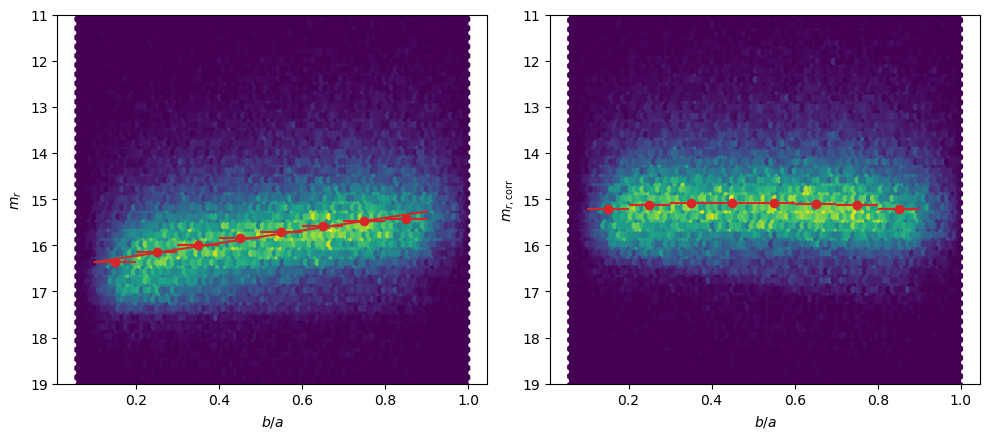

In [11]:
#- Kelly applies an empirical fit to the internal dust in each galaxy. Steps:
#   1. Apply "known" corrections (k-correction, MW dust).
#   2. Fit m_r_corr (corrected) vs spiral b/a
#   3. Zero out this linear dependence.

#- Set up a binned data set and perform the fit
ba_bins = np.arange(0.1,1,0.1)
ba = 0.5*(ba_bins[1:] + ba_bins[:-1])
ba_err = 0.5*np.diff(ba_bins)
m_r_median = np.median(iron['R_MAG_SB26_tmp'])
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='median', bins=ba_bins)
n_bin, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='count', bins=ba_bins)
m_r_err, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], statistic='std', bins=ba_bins)
m_r_err /= np.sqrt(n_bin)

linear_fit = lambda coeff, x: coeff[0]*x + coeff[1]
model = Model(linear_fit)
data = RealData(ba, m_r - m_r_median, sx=ba_err, sy=m_r_err)
odr = ODR(data, model, beta0=[1, 1])

result = odr.run()
coeff = result.beta
coeff_err = result.sd_beta
print('Best fit:    ', coeff)
print('uncertainty: ', coeff_err)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True)#, sharey=True)
ax = axes[0]
# ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'], alpha=0.01)
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'])
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:red')
ax.plot(ba_bins, coeff[0]*ba_bins + coeff[1] + m_r_median, color='tab:red')
ax.set(ylim=(19, 11),
       ylabel='$m_{r}$',
       xlabel='$b/a$');

#- Compute the internal dust correction
A_int, A_int_err = tfpc.internal_dust(iron['BA_ratio'].values, coeff, coeff_err)

ax = axes[1]
# ax.scatter(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, alpha=0.01)
ax.hexbin(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int)
m_r, _, _ = binned_statistic(iron['BA_ratio'], iron['R_MAG_SB26_tmp'] - A_int, statistic='median', bins=ba_bins)
ax.errorbar(ba, m_r, xerr=ba_err, yerr=m_r_err, fmt='o', color='tab:red')
ax.set(ylim=(19, 11),
       ylabel='$m_{r,\mathrm{corr}}$',
       xlabel='$b/a$')

# fig.savefig('tfr_mock_internal_dust_correction.png', dpi=150);

#- Update the r-band magnitudes
iron['R_MAG_SB26_CORR'] = iron['R_MAG_SB26_tmp'] - A_int
iron['R_MAG_SB26_ERR_CORR'] = np.sqrt(iron['R_MAG_SB26_ERR_tmp']**2 + A_int_err**2)

## BGS Mock Catalog

Read in one of the mock catalog files and cross-match to iron.

In [12]:
#- There are 25 BGS mocks and (usually) 27 realizations per mock.
#  Pick one, it doesn't matter which.
mockfiles = sorted(glob(os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base*.hdf5')))
n_mock = len(mockfiles)
mockfile = mockfiles[1]
# mockfile = mockfiles[np.random.randint(n_mock)]
# mockfile = os.path.join(pvpath, 'mocks/BGS_base/v0.5/iron/BGS_PV_AbacusSummit_base_c000_ph000_r001_z0.11.dat.hdf5')

print(f'Picked mock file {os.path.basename(mockfile)}.')

Picked mock file BGS_PV_AbacusSummit_base_c000_ph000_r001_z0.11.dat.hdf5.


In [13]:
#- Fill the catalog as a dictionary and convert to a Pandas table.
#  Here we follow the I/O from the FP generator (thanks Cullan).
mock = {}
with h5py.File(mockfile, 'r') as f:
    for key in f.keys():
        if key == 'vel':
            #- Pack the galaxy velocities into labeled vx, vy, vz
            mock['vx'] = f['vel'][:,0]
            mock['vy'] = f['vel'][:,1]
            mock['vz'] = f['vel'][:,2]
        else:
            mock[key] = f[key][()]

        # convert strings to unicode
        if key == 'survey' or key == 'program':
            mock[key] = mock[key].astype('U')

    #- Convert to a pandas table
    mock = pd.DataFrame.from_dict(mock)

    #- Merge with iron on 4 keywords
    mock = mock.merge(iron, how='inner', on=['targetid', 'survey', 'program', 'healpix'])

In [14]:
mock.keys()

Index(['Y1_COMP', 'Y3_COMP', 'Y5', 'abs_mag', 'app_mag', 'col', 'col_obs',
       'dec', 'halo_mass', 'healpix', 'is_cen', 'is_res', 'program', 'ra',
       'survey', 'targetid', 'vx', 'vy', 'vz', 'zcos', 'zobs', 'target_dec',
       'target_ra', 'z', 'zerr', 'zwarn', 'morphtype', 'sersic', 'mag_g',
       'mag_r', 'mag_z', 'uncor_radius', 'BA_ratio', 'circ_radius',
       'circ_radius_err', 'SGA_id', 'radius_SB25', 'inbasiccuts',
       'has_corrupt_phot', 'deltachi2', 'mag_err_g', 'mag_err_z', 'mag_err_r',
       'SGA_ra', 'SGA_dec', 'D26', 'G_MAG_SB26', 'G_MAG_SB26_ERR',
       'R_MAG_SB26', 'R_MAG_SB26_ERR', 'Z_MAG_SB26', 'Z_MAG_SB26_ERR',
       'photsys', 'G_MAG_SB26_tmp', 'G_MAG_SB26_ERR_tmp', 'R_MAG_SB26_tmp',
       'R_MAG_SB26_ERR_tmp', 'Z_MAG_SB26_tmp', 'Z_MAG_SB26_ERR_tmp',
       'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR'],
      dtype='object')

In [15]:
mock

Y1_COMP   Y3_COMP    Y5    abs_mag    app_mag       col   col_obs  \
0       1.000000  0.991803  True -21.603735  16.064020  0.973818  1.000261   
1       0.000000  0.962963  True -22.974319  14.690473  0.943890  0.969189   
2       1.000000  1.000000  True -20.328584  17.335948  0.754470  0.772327   
3       0.992857  0.992857  True -22.095708  15.565224  0.963012  0.988384   
4       1.000000  1.000000  True -20.940196  16.710539  0.752585  0.769231   
...          ...       ...   ...        ...        ...       ...       ...   
460957  0.845070  0.964789  True -20.442594  17.215514  1.041612  1.067414   
460958  0.993506  1.000000  True -20.977689  16.686527  0.941542  0.966701   
460959  0.609023  0.969925  True -21.044177  16.615062  0.952042  0.976926   
460960  0.958333  1.000000  True -21.492587  16.173641  1.003167  1.029903   
460961  0.886905  0.994048  True -19.926223  17.697176  0.774154  0.789158   

             dec     halo_mass  healpix  ...  Z_MAG_SB26_ERR  photsys  \
0      -0.999080  6.546589e+12    11943  ...        0.020302        N   
1       4.955850  1.250601e+14    19362  ...        0.017098        S   
2       4.141360  1.098831e+12     9063  ...        0.040119        S   
3      -2.295285  3.791707e+13     8866  ...        0.005774        S   
4      -2.161120  3.737292e+12    19996  ...        0.010283        S   
...          ...           ...      ...  ...             ...      ...   
460957  1.054418  1.092504e+12    11953  ...        0.050015        N   
460958 -5.495919  2.952714e+12    27655  ...        0.012371        S   
460959  1.892966  4.370017e+12    27655  ...        0.012371        S   
460960 -2.016671  1.960813e+13    25531  ...        0.013396        S   
460961  1.138406  8.054793e+13     8796  ...        0.035210        S   

       G_MAG_SB26_tmp  G_MAG_SB26_ERR_tmp R_MAG_SB26_tmp  R_MAG_SB26_ERR_tmp  \
0           16.836736            0.037406      15.854162            0.031360   
1           15.576678            0.038922      14.651459            0.027936   
2           17.698509            0.047886      16.911085            0.042496   
3           16.485955            0.026155      15.494399            0.018091   
4           17.428144                 NaN      16.809270                 NaN   
...               ...                 ...            ...                 ...   
460957      17.797096            0.047117      16.751333            0.048677   
460958      17.540445            0.025481      16.560813            0.019910   
460959      17.540445            0.025481      16.560813            0.019910   
460960      17.045383            0.032928      16.025221            0.024078   
460961      17.911914            0.044089      17.107244            0.039024   

        Z_MAG_SB26_tmp  Z_MAG_SB26_ERR_tmp  R_MAG_SB26_CORR  \
0            15.381491            0.030668        15.524017   
1            14.005386            0.022183        14.201208   
2            16.283822            0.041635        15.838278   
3            14.805653            0.011323        15.381549   
4            16.361631                 NaN        16.666891   
...                ...                 ...              ...   
460957       15.985596            0.054987        15.699726   
460958       15.957129            0.015125        16.226617   
460959       15.957129            0.015125        16.226617   
460960       15.330357            0.017762        15.912114   
460961       16.519934            0.036990        16.029573   

        R_MAG_SB26_ERR_CORR  
0                  0.037593  
1                  0.039746  
2                  0.079649  
3                  0.019429  
4                       NaN  
...                     ...  
460957             0.082036  
460958             0.028927  
460959             0.028927  
460960             0.025104  
460961             0.078116  

[460962 rows x 61 columns]

### Apply TF Selection Cuts

Here apply the late-type galaxy cuts defined in *Target Selection for the DESI Peculiar Velocity Survey*, C. Saulder+, MNRAS 525:1106, 2023. Note that several cuts are the complement of the early-type cuts for the FP sample.

In [16]:
mock_selection = {
    'basic cuts' : 0,
    # 'z < 0.1' : 0,
    'b/a < cos(25°)' : 0,
    'morphtype' : 0,
    'NaN' : 0
}

#- Apply target selection
print(f'Size of cross-matched iron+mock catalog ..{len(mock):.>20d}')

#- Drop data that doesn't pass the photometric cuts
select = (mock['inbasiccuts'] == 0) | (mock['has_corrupt_phot'] == 1)
mock = mock.drop(mock[select].index)
mock_selection['basic cuts'] = len(mock)
print(f'Size after photometric cuts .........{len(mock):.>20d}')

#- Redshift range cut: remove?
# select = mock['zobs'] <= 0.105
# mock = mock[select]
# mock_selection['z < 0.1'] = len(mock)
# print(f'Redshift selection: z < 0.1 {len(mock):.>29d}')

#- B/A ratio cut:
select = mock['BA_ratio'] < np.cos(np.radians(25))
mock = mock[select]
mock_selection['b/a < cos(25°)'] = len(mock)
print(f'Ratio b/a < cos(25 deg) .............{len(mock):.>20d}')

#- Morphology cuts:
select = (mock['morphtype'] == 'EXP') | ((mock['morphtype'] == 'SER') & (mock['sersic'] <= 2))
mock = mock[select]
mock_selection['morphtype'] = len(mock)
print(f'Morphology cuts: ....................{len(mock):.>20d}')

#- Drop any rows with NaN
mock = mock.dropna()
mock_selection['NaN'] = len(mock)
print(f'Drop NaN ............................{len(mock):.>20d}')

Size of cross-matched iron+mock catalog ................460962
Size after photometric cuts .......................460765
Ratio b/a < cos(25 deg) ...........................445228
Morphology cuts: ..................................237495
Drop NaN ..........................................203127


/tmp/ipykernel_1470637/1003090540.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(names, rotation=45, ha='right')


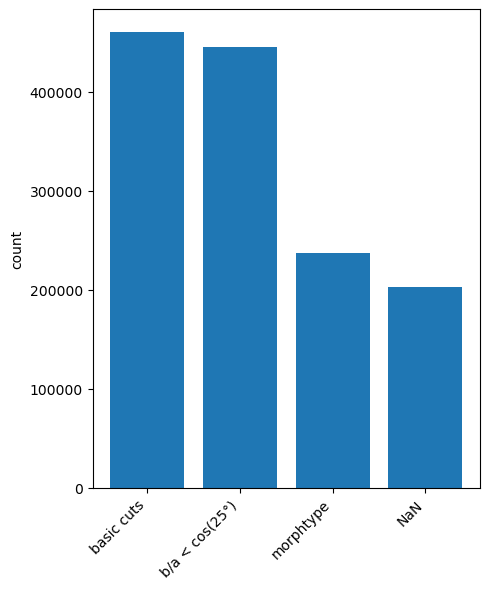

In [17]:
names = list(mock_selection.keys())
values = list(mock_selection.values())

fig, ax = plt.subplots(1, 1, figsize=(5,6), tight_layout=True)
bars = ax.bar(names, values)
ax.set_xticklabels(names, rotation=45, ha='right')
# ax.bar_label(bars, fmt='%d')
ax.set(ylabel='count');#, yscale='log', ylim=[1e3,1.2e4]);
# fig.savefig('tfr_mock_cuts.png', dpi=150)

## Compute TFR Quantities

Assign a rotational velocity using the data. Then use this to infer $M_r$ using the calibrated TFR.

### Set up the Cosmology

Use a flat-$\Lambda$CDM fiducial cosmology with $H_0\equiv100$ km/s/Mpc and $\Omega_m=0.3151$.

In [18]:
h = 1

cosmology = FlatLambdaCDM(H0=100*h, Om0=0.3151)

### Current Y1 TFR Best Fit

TF Y1 best-fit parameters and covariances, corresponding to v8 of the TF Y1 catalog. This comes from the TFR calibration using redshift bins of width $dz = 0.005$ for galaxies with $0.03 < z < 0.1$ using Vmax weights to account for the galaxy size function. The TFR fit is

$$
M_r = a \log_{10}{\left(\frac{V_\mathrm{rot}}{V_0}\right)} + b_{0\mathrm{pt}}
$$

with intrinsic scatter $\sigma$ along the magnitude axis. See this [notebook](https://github.com/DESI-UR/DESI_SGA/blob/master/TF/Y1/TF_Y1_zbin_calibration_weightsVmax-1_cutsAlex_KAD.ipynb) in the [DESI_SGA/TF/Y1](https://github.com/DESI-UR/DESI_SGA/tree/master/TF/Y1) GitHub repo.

The parameter vector includes the TFR slope $a$, redshift-bin zero points $b_i$ (in apparent magnitude space), and intrinsic scatter $\sigma$.

In [19]:
with open('../cov_ab_iron_jointTFR_varyV0-dwarfsAlex_z0p1_zbins0p005_weightsVmax-1_dVsys_20251030.pickle', 'rb') as tfr_file:
    tf_cov, tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(tfr_file)

# Store TF best-fit parameters.
tf_par = np.median(tfr_samples, axis=1)
a = tf_par[0]
sigma = tf_par[-1]
b = tf_par[1:-1]

### Current TFR Catalog

Read in the TFR catalog to sample uncertainties in $V_\mathrm{rot}$.

In [20]:
tfr_version = 'v15'

tfrcatfile = os.path.join(pvpath, f'tfgalaxies/Y1/DESI-DR1_TF_pv_cat_{tfr_version}.fits')
tfrcat = Table.read(tfrcatfile)

tfrcat['logv_rot'] = np.log10(tfrcat['V_0p4R26'])
tfrcat['logv_rot_err'] = 0.434*tfrcat['V_0p4R26_ERR'] / tfrcat['V_0p4R26']

tfrcat = tfrcat['Z_DESI', 'D26', 'R_MAG_SB26_CORR', 'R_MAG_SB26_ERR_CORR', 'R_ABSMAG_SB26', 'R_ABSMAG_SB26_ERR', 'MAIN', 'MU_ZCMB', 'MU_ZCMB_ERR', 'V_0p4R26', 'V_0p4R26_ERR', 'logv_rot', 'logv_rot_err', 'LOGDIST', 'LOGDIST_ERR'].to_pandas()
tfrcat

Z_DESI       D26  R_MAG_SB26_CORR  R_MAG_SB26_ERR_CORR  \
0      0.080990  0.417579        16.712828             0.107923   
1      0.044002  0.495681        16.874759             0.086265   
2      0.090040  0.567250        15.937208             0.111025   
3      0.034026  0.575771        16.641523             0.097170   
4      0.043319  0.953031        15.206748             0.141361   
...         ...       ...              ...                  ...   
10195  0.116921  0.369286        16.646621             0.077811   
10196  0.054449  0.376227        17.079648             0.044823   
10197  0.118856  0.362001        17.636989             0.070637   
10198  0.133822  0.454465        17.362494             0.137150   
10199  0.056664  0.569711        16.536669             0.111050   

       R_ABSMAG_SB26  R_ABSMAG_SB26_ERR   MAIN    MU_ZCMB  MU_ZCMB_ERR  \
0         -20.357827           0.107926   True  37.070655     0.000725   
1         -18.851691           0.086274   True  35.726451     0.001286   
2         -21.388354           0.111029   True  37.325563     0.000922   
3         -18.509705           0.097183   True  35.151228     0.001586   
4         -20.468399           0.141368   True  35.675148     0.001457   
...              ...                ...    ...        ...          ...   
10195     -21.258442           0.077813   True  37.905063     0.000546   
10196     -19.081658           0.044837  False  36.161306     0.001105   
10197     -20.308671           0.070646  False  37.945660     0.001151   
10198     -20.860460           0.137152  False  38.222953     0.000731   
10199     -19.711286           0.111056   True  36.247955     0.001136   

         V_0p4R26  V_0p4R26_ERR  logv_rot  logv_rot_err   LOGDIST  LOGDIST_ERR  
0      122.322388     10.869519  2.087506      0.038565  0.069190     0.107068  
1       81.348133      6.577976  1.910348      0.035094  0.024990     0.103286  
2      180.655725     13.281536  2.256852      0.031907  0.049015     0.102311  
3       70.102003     12.043673  1.845730      0.074562  0.064818     0.143577  
4      133.778523     10.944416  2.126386      0.035506  0.042852     0.106439  
...           ...           ...       ...           ...       ...          ...  
10195   95.032991     12.384687  1.977874      0.056559  0.429497     0.122660  
10196   44.540700     19.033877  1.648757      0.185464  0.443171     0.365870  
10197  123.942591     22.458671  2.093221      0.078642  0.074707     0.148994  
10198  172.888233     18.437635  2.237765      0.046284 -0.021498     0.114486  
10199   78.660236     12.496419  1.895755      0.068948  0.215416     0.137162  

[10200 rows x 15 columns]

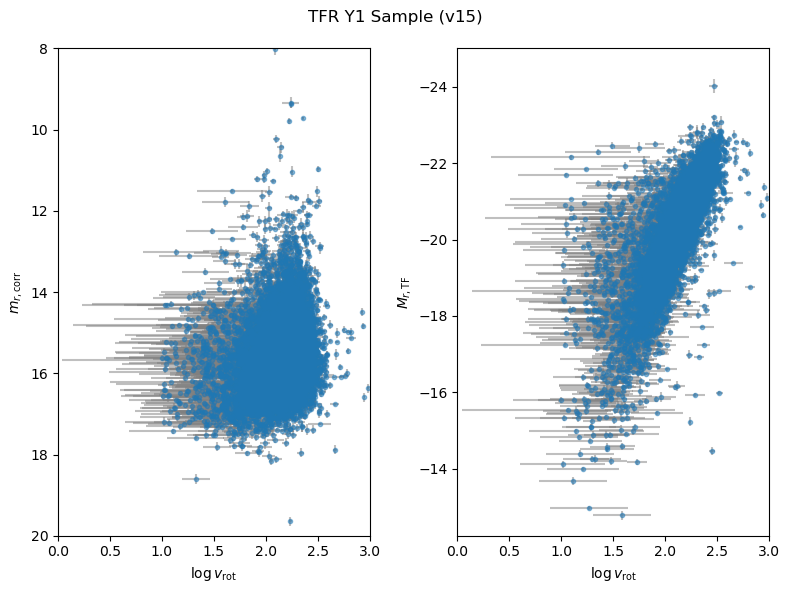

In [21]:
fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True)

ax = axes[0]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_MAG_SB26_CORR'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_MAG_SB26_ERR_CORR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{corr}}$',
       ylim=(20,8))

ax = axes[1]
ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
             xerr=tfrcat['logv_rot_err'],
             yerr=tfrcat['R_ABSMAG_SB26_ERR'],
             fmt='.', 
             alpha=0.5, 
             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{TF}}$',
       ylim=(-12.25, -25))

fig.suptitle(f'TFR Y1 Sample ({tfr_version})');
# fig.savefig('tfr_y1_sample.png', dpi=180);

### Generate Absolute Magnitudes for TFR Fitting

Procedure:
1. Calculate $M_{r,\mathrm{cos}}$ using $z_\mathrm{cos}$ from the mocks. This explicitly excludes mock peculiar velocities.
2. Compute distance moduli $\mu$ for each *observed* redshift in the mocks, $z_\mathrm{obs}$.
3. Compute $M_{r,\mathrm{obs}}$ using $m_{r,\mathrm{SB26}}$ from cross-matched from data and the generated $\mu$.
4. Sample $\log{V_\mathrm{rot}}$ by binning the Y1 data in magnitude, computing the $\log{v_\mathrm{rot}}$ CDF in each bin, and randomly sampling a value for each mock galaxy.

In [22]:
#- 1. distmod with cosmological redshifts to compute a "true" absolute magnitude M_r(SB26).
Mr_cos_mock = mock['R_MAG_SB26_CORR'] - cosmology.distmod(mock['zcos']).to_value('mag')

#- 2. Compute an observed magnitude based on the PVs in the mock catalog.
mu_obs_mock = cosmology.distmod(mock['zobs']).to_value('mag')
mock['MU_OBS_MOCK'] = mu_obs_mock
Mr_obs_mock = (mock['R_MAG_SB26_CORR'] - mu_obs_mock).to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

#- Bin R_ABSMAG_SB26. Merge any bins with < 50 datapoints, working from the ends of the magnitude range.
bins = np.arange(-26, -12 + 0.05, 0.05)
M_r_bins = [bins[0]]
for k in np.arange(1, len(bins)):
    select = (tfrcat['R_ABSMAG_SB26'] > M_r_bins[-1]) & (tfrcat['R_ABSMAG_SB26'] <= bins[k])    
    if np.sum(select) >= 50:
        M_r_bins.append(bins[k])
M_r_bins.append(bins[-1])
N_bins = len(M_r_bins)

print(np.histogram(tfrcat['R_ABSMAG_SB26'], M_r_bins))

#- Loop through the magnitude bins and generate log(v_rot) by resampling the data.
#  Try to reduce resampling effects by using a smoothed version of the CDF of log(v_rot).
logvrot_mock = np.zeros(len(Mr_cos_mock))

use_weighted_fit = True

for k in tqdm(np.arange(0, N_bins-1)):
    M_r_min, M_r_max = M_r_bins[k], M_r_bins[k+1]

    #- Select TFR velocity data in this magnitude bin and compute the CDF of log(v_rot).
    i = (tfrcat['R_ABSMAG_SB26'] > M_r_min) & (tfrcat['R_ABSMAG_SB26'] <= M_r_max)
    logvrot_slice = tfrcat['logv_rot'][i].to_numpy()
    logvrot_err_slice = tfrcat['logv_rot_err'][i].to_numpy()

    if use_weighted_fit:
        #-Attempt to built a weighted CDF
        logvrot_bins = np.arange(1, 3.01, 0.01)
        logvrot_pdf_wt, logv_bins = np.histogram(logvrot_slice, bins=logvrot_bins, 
                                                 weights=np.ones_like(logvrot_err_slice)
                                                 # weights=1/logvrot_err_slice**2
                                                )
        logvrot_cdf = np.cumsum(logvrot_pdf_wt) / np.sum(logvrot_pdf_wt)
        
        logvrot_slice = 0.5*(logvrot_bins[1:] + logvrot_bins[:-1])

        #- Keep only the unique elements in the list
        idx = np.cumsum([len(list(g)) for k, g in groupby(logvrot_cdf)])[:-1]
        logvrot_cdf = logvrot_cdf[idx]
        logvrot_slice = logvrot_slice[idx]
        # print(logvrot_cdf.shape, logvrot_slice.shape)
    else:
        #- Default to use the unweighted CDF
        logvrot_cdf = np.cumsum(logvrot_slice) / np.sum(logvrot_slice)

    #- Select mock data in this magnitude bin.
    # j = (Mr_obs_mock > M_r_min) & (Mr_obs_mock <= M_r_max)
    j = (Mr_cos_mock > M_r_min) & (Mr_cos_mock <= M_r_max)
    N_mock_slice = np.sum(j)
    un = np.random.uniform(size=N_mock_slice)
    logvrot_mock_slice = csaps(logvrot_cdf, np.sort(logvrot_slice), un).values
    logvrot_mock[j] = logvrot_mock_slice

    #- Apply a velocity cut of 10 to 1000 km/s.
    #  Regenerate any velocities that fall outside the valid range.
    #  Note that an intermediate variable is needed to manage the array slicing.
    bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
    # bad_vrot = (logvrot_mock[j] < logVmin) | (logvrot_mock[j] > logVmax) | (logvrot_mock[j] > logVMmax[j])
    while np.any(bad_vrot):
        N_regen = np.sum(bad_vrot)
        uni = np.random.uniform(size=N_regen)
        logvrot_mock_regen = logvrot_mock[j]
        logvrot_mock_regen[bad_vrot] = csaps(logvrot_cdf, np.sort(logvrot_slice), uni).values
        logvrot_mock[j] = logvrot_mock_regen
        bad_vrot = (logvrot_mock[j] < 1) | (logvrot_mock[j] > 3)
        # bad_vrot = (logvrot_mock[j] < logVmin) | (logvrot_mock[j] > logVmax) | (logvrot_mock[j] > logVMmax[j])

# #- Next, scatter in the Mr_obs, logvrot plane using the sigma fit from the data,
# #  projected onto the best fit line in the TFR Y1 *data*. Use this projected sigma
# #  to scatter the mock Mr_obs vs logvrot.
# slope = np.asarray([-a, 1.])
# slope = slope / np.sqrt(np.dot(slope, slope))

# logging.warning('Using a fudge factor in sigma. Revisit!')
# scale = np.random.normal(0, 0.13*sigma, len(Mr_obs))
# logvrot_mock = logvrot + scale*slope[0]
# Mr_obs_mock = Mr_obs + scale*slope[1]

#- Finally, match mock values against the Y1 data to assign uncertainties on logvrot_mock and Mr_obs_mock.
#  Many ways to do this... here just copy the FP approach of grabbing the nearest neighbor in (log v, M_r)
#  from data and taking its uncertainty.
search_tree = KDTree(np.c_[tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26']])
search_tree.query([1.5, -20])
_, idx = search_tree.query([[x, y] for (x,y) in zip(logvrot_mock, Mr_obs_mock)])

logvrot_err_mock = tfrcat['logv_rot_err'][idx].to_numpy()
Mr_obs_err_mock = mock['R_MAG_SB26_ERR_CORR'].to_numpy()

mock['LOGVROT_MOCK'] = logvrot_mock
mock['LOGVROT_ERR_MOCK'] = logvrot_err_mock
mock['R_ABSMAG_SB26_MOCK'] = Mr_obs_mock
mock['R_ABSMAG_SB26_ERR_MOCK'] = Mr_obs_err_mock

(array([ 51,  57,  77,  74,  57,  52,  63,  61,  81,  76, 107, 114, 118,
       128, 147, 161, 154, 163, 161, 167, 169, 177, 206, 156, 211, 215,
       181, 181, 197, 179, 198, 169, 168, 179, 200, 174, 163, 167, 164,
       165, 165, 146, 152, 168, 150, 141, 140, 134, 130, 129, 105, 125,
       113, 102, 127,  97, 106,  93,  87,  95,  99,  87,  87,  90,  72,
        56,  70,  71,  61,  51,  52,  54, 100,  67,  94,  87,  86,  65,
        68,  61,  68,  56,  62,  50,  53,  55,  51,  51,  53,  30]), array([-26.  , -22.55, -22.4 , -22.25, -22.15, -22.1 , -22.05, -22.  ,
       -21.95, -21.9 , -21.85, -21.8 , -21.75, -21.7 , -21.65, -21.6 ,
       -21.55, -21.5 , -21.45, -21.4 , -21.35, -21.3 , -21.25, -21.2 ,
       -21.15, -21.1 , -21.05, -21.  , -20.95, -20.9 , -20.85, -20.8 ,
       -20.75, -20.7 , -20.65, -20.6 , -20.55, -20.5 , -20.45, -20.4 ,
       -20.35, -20.3 , -20.25, -20.2 , -20.15, -20.1 , -20.05, -20.  ,
       -19.95, -19.9 , -19.85, -19.8 , -19.75, -19.7 , -19.65, -19.6 ,
 

100%|██████████| 90/90 [00:00<00:00, 282.78it/s]


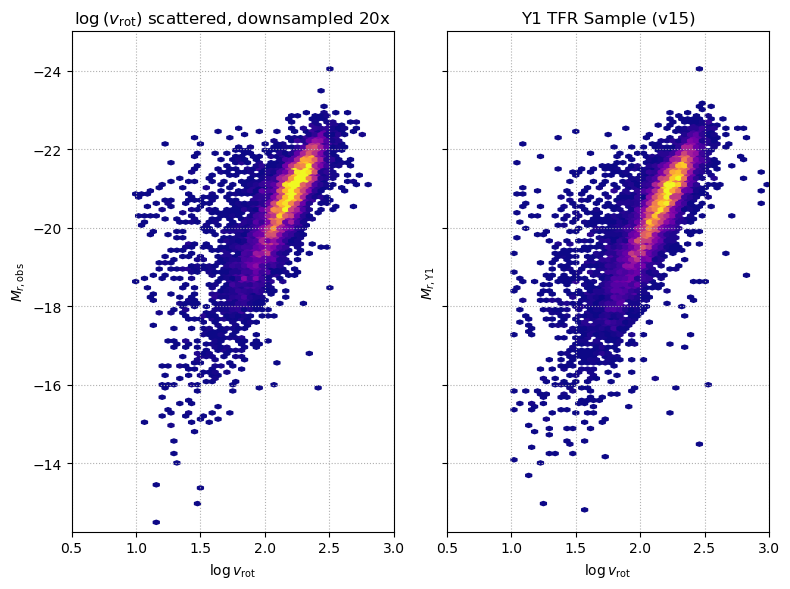

In [33]:
#- Plot Mr vs log(v_rot) for the various steps in the calculation.

fig, axes = plt.subplots(1,2, figsize=(8,6), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.grid(ls=':')
ax.hexbin(mock['LOGVROT_MOCK'][::20], 
          mock['R_ABSMAG_SB26_MOCK'][::20],
          cmap='plasma', 
          mincnt=1, 
          vmin=1, 
          vmax=70, 
          gridsize=(70,80), 
          extent=(-0.1, 3.1, -25, -12.25))
# ax.errorbar(mock['LOGVROT_MOCK'][::20], mock['R_ABSMAG_SB26_MOCK'][::20],
#             xerr=mock['LOGVROT_ERR_MOCK'][::20],
#             yerr=mock['R_ABSMAG_SB26_ERR_MOCK'][::20],
#             fmt='.', 
#             alpha=0.5, 
#             ecolor='gray')

ax.set(xlim=(0,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{obs}}$',
       ylim=(-12.25, -25),
       title=r'$\log{(v_\mathrm{rot})}$ scattered, downsampled 20x')

ax = axes[1]
ax.grid(ls=':')
ax.hexbin(tfrcat['logv_rot'], 
          tfrcat['R_ABSMAG_SB26'],
          cmap='plasma', 
          mincnt=1, 
          vmin=1, 
          vmax=70, 
          gridsize=(70,80), 
          extent=(-0.1, 3.1, -25, -12.25))
# ax.errorbar(tfrcat['logv_rot'], tfrcat['R_ABSMAG_SB26'],
#              xerr=tfrcat['logv_rot_err'],
#              yerr=tfrcat['R_ABSMAG_SB26_ERR'],
#              fmt='.', 
#              alpha=0.5, 
#              ecolor='gray')

ax.set(xlim=(0.5,3),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{Y1}}$',
       ylim=(-12.25, -25),
       title=f'Y1 TFR Sample ({tfr_version})');

# fig.savefig('tfr_mock_mr_vs_logv.png', dpi=150);

### Compute the Maximum Volume for each Galaxy

Since the SGA is size-limited, with $D_{26}>0.2'$, there is a maximum volume within which the galaxy could be located to be included in the SGA. Calculate the maximum volume to be used as a weight in the TFR calibration.

In [24]:
dist = cosmology.luminosity_distance(np.abs(mock['zobs']))
dist_max = cosmology.luminosity_distance(z=0.1)
d26_kpc = 2*dist.to('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
mock_dist_max = 0.5*d26_kpc / np.tan(0.1*u.arcmin)
# surv_max = cosmology.luminosity_distance(z=0.2)

# mock['D26_kpc'] = 2*dist.to_value('kpc') * np.tan(0.5*mock['D26'].values*u.arcmin)
# mock['DIST_MAX'] = 0.5*mock['D26_kpc'].values / np.tan(0.1*u.arcmin)
# mock['MAX_VOL_FRAC'] = (1e-3 * mock['DIST_MAX'].values)**3 / dist_max.to_value('Mpc')**3
mock['MAX_VOL_FRAC'] = mock_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3

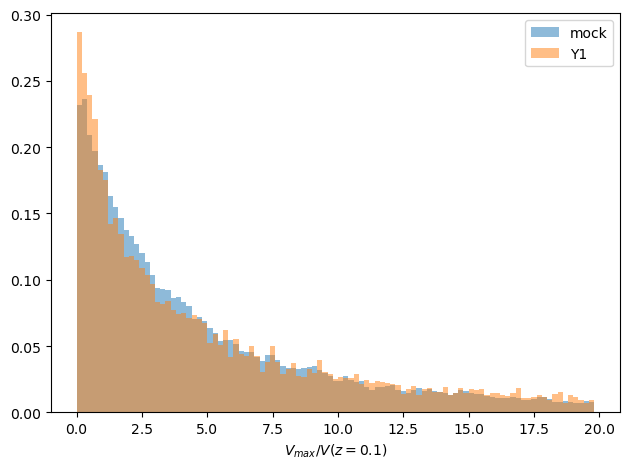

In [25]:
plt.figure(tight_layout=True)

iron_dist = cosmology.luminosity_distance(np.abs(tfrcat['Z_DESI'].values))
iron_d26kpc = 2*iron_dist.to('kpc') * np.tan(0.5*tfrcat['D26'].values*u.arcmin)
iron_dist_max = 0.5*iron_d26kpc / np.tan(0.1*u.arcmin)

plt.hist(mock['MAX_VOL_FRAC'], np.arange(0, 20, 0.2), density=True, alpha=0.5, label='mock')
plt.hist(iron_dist_max.to('Mpc')**3 / dist_max.to('Mpc')**3, np.arange(0, 20, 0.2), density=True, alpha=0.5, label='Y1')

plt.legend()

plt.xlabel('$V_{max}$/$V(z = 0.1)$');

### What is the size distribution of galaxies with $M_r > -17$?

Our usual definition of a dwarf galaxy is to have $M_r > -17$.  Because we don't know this for the data a priori, can we use the galaxy's size as a proxy?

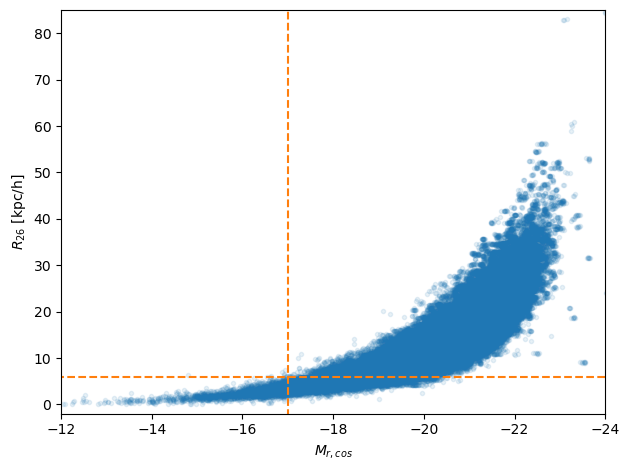

In [26]:
plt.figure(tight_layout=True)

plt.plot(Mr_cos_mock, 0.5*d26_kpc, '.', alpha=0.1)

plt.vlines(-17, -5, 90, colors='tab:orange', linestyles='dashed')
plt.hlines(6, -24, -12, colors='tab:orange', linestyles='dashed')

plt.xlim(-12, -24)
plt.ylim(-2, 85)

plt.xlabel('$M_{r, cos}$')
plt.ylabel('$R_{26}$ [kpc/h]');

### Apply Alex's velocity and dwarf cuts

In [27]:
# Alex's definition for dwarfs
Rlim = 17.75
Mlim = -17 + 5*np.log10(h)

Rlim_eff = np.minimum(Rlim, mock['MU_OBS_MOCK'] + Mlim)
mock_dwarfs = mock['R_MAG_SB26'] > Rlim_eff

#### Implement Alex's velocity cuts

In [28]:
# Alex's velocity cuts
logVmin = np.log10(70)
logVmax = np.log10(300)

logVM_slope = 0.3
logVM_zero = 34 + 5*np.log10(h)

logVMmax = np.minimum(logVmax, logVM_slope*(mock['MU_OBS_MOCK'] - logVM_zero) + 2)
mock_goodV = (mock['LOGVROT_MOCK'] > logVmin) & (mock['LOGVROT_MOCK'] < logVmax) & (mock['LOGVROT_MOCK'] < logVMmax)

#### Create a "data" sample with which to fit

In [29]:
def downsample(mock, size=100):
    """Randomly downsample a mock catalog, without replacement, to some size.

    Parameters
    ----------
    mock: pandas.DataFrame
        Pandas table with a mock catalog.
    size: int
        Size of the final downsampled catalog.

    Returns
    -------
    newmock: pandas.DataFrame
        Downsampled Pandas table.
    """
    Nmock = len(mock)
    idx_downsample = np.random.choice(Nmock, size, replace=False)
    return mock.iloc[idx_downsample]

In [32]:
#- Only use non-dwarf galaxies with good velocities
mock_main = ~mock_dwarfs & mock_goodV

print(sum(~mock_dwarfs), sum(mock_goodV))
print(sum(mock_main), len(mock))

Ntfr = 4918 # Number of objects in Y1 that made it through all the calibration cuts
mock_downsample = downsample(mock[mock_main], Ntfr)

194024 165183
162555 203127


### Fit the TFR and Compute Mock Distance Moduli

Fit $M_{r,\mathrm{obs,mock}}$ versus $\log{V_\mathrm{rot,mock}}$ to get a mock TFR.

Then compute the TF distance modulus as

$$
\mu_\mathrm{mock} = m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{obs,mock}},
$$

where the apparent magnitude is the quantity `R_MAG_SB26_CORR` used to compute magnitudes from the cosmological and observed redshift.

In [33]:
# Bin the galaxies
zbin_indices = np.digitize(mock['zobs'], zbins, right=True)
zbin_indices_downsample = np.digitize(mock_downsample['zobs'], zbins, right=True)

In [34]:
for i in range(len(zbins) + 1):
    if i == 0:
        print(f'{i:2d}  z <= {zbins[i]:0.3f}  {np.sum(zbin_indices_downsample == i):3d} galaxies')
    elif i == len(zbins):
        print(f'{i:2d}  z > {zbins[i-1]:0.3f}  {np.sum(zbin_indices_downsample == i):3d} galaxies')
    else:
        print(f'{i:2d}  {zbins[i-1]:0.3f} < z <= {zbins[i]:0.3f}  {np.sum(zbin_indices_downsample == i):3d} galaxies')

 0  z <= 0.030  384 galaxies
 1  0.030 < z <= 0.035  366 galaxies
 2  0.035 < z <= 0.040  438 galaxies
 3  0.040 < z <= 0.045  457 galaxies
 4  0.045 < z <= 0.050  427 galaxies
 5  0.050 < z <= 0.055  416 galaxies
 6  0.055 < z <= 0.060  368 galaxies
 7  0.060 < z <= 0.065  315 galaxies
 8  0.065 < z <= 0.070  330 galaxies
 9  0.070 < z <= 0.075  272 galaxies
10  0.075 < z <= 0.080  270 galaxies
11  0.080 < z <= 0.085  223 galaxies
12  0.085 < z <= 0.090  181 galaxies
13  0.090 < z <= 0.095  167 galaxies
14  0.095 < z <= 0.100  112 galaxies
15  z > 0.100  192 galaxies


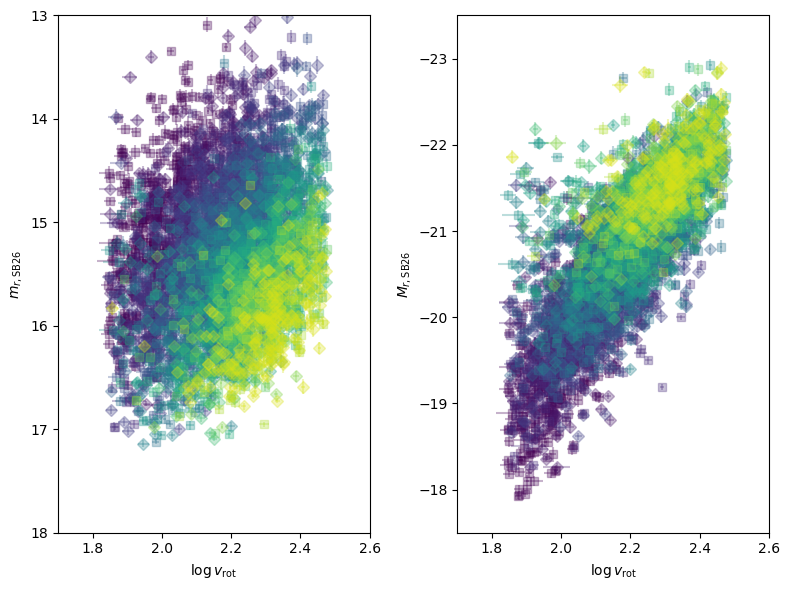

In [35]:
fig, axes = plt.subplots(1,2, figsize=(8,6), sharex=True, tight_layout=True)

_zbin_ids = np.sort(np.unique(zbin_indices_downsample))
n_zbins = len(_zbin_ids)

markers = 'sDv^<>'

colors = iter(plt.cm.viridis(np.linspace(0,1, n_zbins + 1)))

for j, _zbin_id in enumerate(_zbin_ids):
    select_zbin = np.isin(zbin_indices_downsample, _zbin_id)

    logv = mock_downsample['LOGVROT_MOCK'][select_zbin] #- logV0
    logv_err = 0.434*mock_downsample['LOGVROT_ERR_MOCK'][select_zbin] / mock_downsample['LOGVROT_MOCK'][select_zbin]

    mr26 = mock_downsample['R_MAG_SB26_CORR'][select_zbin]
    mr26_err = mock_downsample['R_MAG_SB26_ERR_CORR'][select_zbin]

    Mr26 = mock_downsample['R_ABSMAG_SB26_MOCK'][select_zbin]
    Mr26_err = mock_downsample['R_ABSMAG_SB26_ERR_MOCK'][select_zbin]

    c = next(colors)

    ax = axes[0]
    ax.errorbar(x=logv, y=mr26, xerr=logv_err, yerr=mr26_err,
                fmt=markers[j % 2], markersize=6, alpha=0.3,
                color=c)

    ax = axes[1]
    ax.errorbar(x=logv, y=Mr26, xerr=logv_err, yerr=Mr26_err,
                fmt=markers[j % 2], markersize=6, alpha=0.3,
                color=c)

ax = axes[0]
ax.set(xlim=(1.7, 2.6),
       ylim=(18, 13),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$m_{r,\mathrm{SB26}}$')

ax = axes[1]
ax.set(ylim=(-17.5, -23.5),
       xlabel=r'$\log{v_\mathrm{rot}}$',
       ylabel=r'$M_{r,\mathrm{SB26}}$');

#### Pack the data for `MultiLinFit`

In [36]:
# Determine logV0 for the test calibration
# logV0_mock = np.median(mock_downsample['LOGVROT_MOCK'])
# print(logV0_mock)

# Pack the calibration set into lists
logv, dlogv = [], []
mr, dmr = [], []
weights = []

# Loop over the redshift bins
for k in range(1,len(zbins)):

    # Identify objects in this bin
    cal_idx = zbin_indices_downsample == k

    # logv.append(mock_downsample['LOGVROT_MOCK'].to_numpy()[cal_idx] - logV0_mock)
    logv.append(mock_downsample['LOGVROT_MOCK'].to_numpy()[cal_idx] - logV0)
    dlogv.append(mock_downsample['LOGVROT_ERR_MOCK'].to_numpy()[cal_idx])
    mr.append(mock_downsample['R_MAG_SB26_CORR'].to_numpy()[cal_idx])
    dmr.append(mock_downsample['R_MAG_SB26_ERR_CORR'].to_numpy()[cal_idx])
    # weights.append(np.ones(np.sum(cal_idx)))
    weights.append(1/mock_downsample['MAX_VOL_FRAC'].to_numpy()[cal_idx])

#### Fit with `MultiLinFit`

In [37]:
# Number of redshift bins
m = len(logv)

bounds = [[-10, -5]]        # Bounds on a (slope)
bounds += m*[(0, 20)]    # Bounds on b (intercepts: z-bins)
bounds += [(0,2)]          # Bounds on sigma

# logging.warning('Fit does not account for volume weights.')

results = hyperfit_line_multi(logv, mr, dlogv, dmr, bounds, weights=weights, scatter=1)
# results = hyperfit_line_multi(logv, mr, dlogv, dmr, bounds, scatter=1)

a_mcmc, b_mcmc, sigma_mcmc, cov_mcmc, mcmc_samples, hf = results

     fun: -1344018.3360722132
     jac: array([  7.28759919,  -2.00234337,   0.95460556,  -3.79513918,
         8.73114841,   0.41909512,   1.07102087,   1.93249418,
         9.96515072,  -2.21189093,  -3.14321343,   7.89295817,
         3.16649649,   3.21306262,  -8.8009976 , -49.31353008])
 message: 'Optimization terminated successfully.'
    nfev: 31060
     nit: 127
 success: True
       x: array([-7.60281489, 14.19508495, 14.6402037 , 14.85922681, 15.16181567,
       15.39430121, 15.62812897, 15.71349543, 15.96199694, 16.07865661,
       16.29871442, 16.40582558, 16.51594379, 16.7150508 , 16.90558158,
        0.53221827])
Ndim: 16 14


100%|██████████| 1000/1000 [00:46<00:00, 21.53it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [70.17494536 59.38819349 44.18652887 47.97545573 46.76123822 54.18741216
 53.98988652 78.00040785 59.38957928 71.64799602 67.4776149  75.83352491
 66.43281668 70.50954295 69.69304455 68.17635268] / 3900.020392691816


100%|██████████| 1000/1000 [00:46<00:00, 21.58it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 82.55670903  65.35040322  58.04033057  60.213384    65.52284209
  73.26089182  64.7517537   70.84705843  78.33508459  81.09205841
  83.09332454  78.959207    85.81791027  84.11280996 101.70648686
  90.02240832] / 5085.324343142291


100%|██████████| 1000/1000 [00:47<00:00, 21.25it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [ 93.26617071  74.0237676   65.3581603   61.88884523  70.65442508
  71.95046321  72.94270192  85.50364741  76.58438293  86.65345315
  90.23383214  94.07134005 106.75336137  98.78755959 109.17273531
 109.54651623] / 5477.325811505941


100%|██████████| 1000/1000 [00:46<00:00, 21.51it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [116.52772572  74.48819761  66.61850582  66.29607463  66.26768036
  79.72362997  75.93913048  90.72565895  80.80578482  93.45877022
  96.8770191  101.07162081 118.90107154 114.3520643  108.72631407
 127.73880399] / 6386.940199620256


100%|██████████| 1000/1000 [00:46<00:00, 21.33it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.10740073  78.86066839  66.82230333  64.36773549  65.589935
  80.50215302  79.92796267  91.37015213  92.39383148  97.59811932
 108.35873319 111.65598259 111.76455405 120.92135568 113.5558459
 129.14957738] / 6457.4788689016


100%|██████████| 1000/1000 [00:49<00:00, 20.32it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [124.57490395  74.96698051  65.53584483  64.46092449  72.87643485
  87.99413641  87.94890584  98.66094669  96.19357459 110.48747293
 104.85588386 109.44589289 113.35835664 113.19737374 127.37934643
 133.13824904] / 6656.912452172446


100%|██████████| 1000/1000 [00:49<00:00, 20.08it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [118.09335042  76.93540961  66.47787111  63.23414191  76.11816243
  83.29900479  84.73600234 100.38846629 104.56545588 110.72306052
 108.15098904 114.22704528 118.88326146 124.57449753 136.37675047
 125.17687072] / 6818.837523357342


100%|██████████| 1000/1000 [00:49<00:00, 20.11it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [120.37355226  76.42472773  69.09088037  63.88148407  80.41955738
  90.93767392  89.90016941 105.03926277  97.00532136 121.25972023
 109.79540698 127.50520669 119.83212785 124.62861598 140.58781204
 125.1812481 ] / 7029.390602231112


100%|██████████| 1000/1000 [00:48<00:00, 20.51it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [127.44892878  75.76025259  65.58469367  65.35896594  79.19411991
  90.4721027   96.24457736 101.23423846  99.16941105 122.94763989
 113.99754336 127.70775022 123.36018848 123.05028529 143.36694765
 133.98853135] / 7168.347382471099


100%|██████████| 1000/1000 [00:49<00:00, 20.15it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [131.32433904  76.25983292  66.76790806  66.5814917   81.58296502
  85.07113761  98.00788967 106.82801304 100.17018152 124.2207492
 120.70596295 136.79709283 126.10463401 132.85088195 147.44758385
 134.97153753] / 7372.379192292334


100%|██████████| 1000/1000 [00:49<00:00, 20.37it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [140.28186188  79.67594716  68.4684492   66.01132746  85.59055257
  84.77702256 101.93806073 108.35193768  92.94728955 121.47120868
 117.13969235 154.62208368 128.41196255 136.26120039 142.98661195
 143.27722322] / 7731.104184126583


100%|██████████| 1000/1000 [00:47<00:00, 20.87it/s]


Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [145.21087673  80.72903822  67.5387855   68.62474755  85.91452872
  86.09861098 101.77926626 106.94049356  95.14536979 126.41039018
 116.27462503 151.71098217 128.59676029 139.77773007 136.75291311
 151.58728051] / 7585.549108311903


100%|██████████| 1000/1000 [00:46<00:00, 21.49it/s]


Niterations/Max Iterations:  13000 / 100000
Integrated ACT/Min Convergence Iterations:  [147.98519122  82.24736948  66.62284875  67.22654633  86.22998914
  85.44068458  99.38167259 111.3017629  101.19923128 120.67708887
 121.16075377 153.35371721 126.94962717 134.5712758  138.62563254
 166.61446065] / 8330.723032475138


100%|██████████| 1000/1000 [00:45<00:00, 21.89it/s]


Niterations/Max Iterations:  14000 / 100000
Integrated ACT/Min Convergence Iterations:  [149.48880798  81.81001295  67.4622552   71.15348514  82.99852357
  83.50339699  99.64355407 104.83307567  99.5995634  123.48329607
 124.9999958  153.76991693 133.3328801  141.41896899 139.70032121
 165.89329086] / 8294.664542883269


100%|██████████| 1000/1000 [00:46<00:00, 21.69it/s]


Niterations/Max Iterations:  15000 / 100000
Integrated ACT/Min Convergence Iterations:  [156.67918846  80.59678929  66.77514471  69.74030473  83.42519774
  82.51905878 100.95376045 103.1696712  102.69625833 128.76338034
 128.04409518 152.16251106 139.46618642 146.37563261 147.47457292
 167.81712669] / 8390.856334729067


100%|██████████| 1000/1000 [00:46<00:00, 21.43it/s]


Niterations/Max Iterations:  16000 / 100000
Integrated ACT/Min Convergence Iterations:  [160.19045995  80.50306458  66.62031527  72.50407642  87.29272228
  85.27486174  99.74343245 103.82160436 108.37816676 126.58380774
 128.20207699 136.18700825 133.5937243  145.99803478 148.44564466
 170.43290543] / 8521.64527133224


100%|██████████| 1000/1000 [00:45<00:00, 21.82it/s]


Niterations/Max Iterations:  17000 / 100000
Integrated ACT/Min Convergence Iterations:  [161.16779635  79.10791863  66.84745267  69.08285759  83.67827075
  85.99049687  99.86967788 104.5119763  106.74798515 124.41615054
 127.89325568 132.25784699 131.14495993 150.19154367 150.89702393
 167.38144686] / 8369.072343177306


In [38]:
values = np.median(mcmc_samples, axis=1)
sigmas = np.sqrt(np.diag(cov_mcmc))

multiple = 3.5

limits = []

for i in range(len(values)):
    limits.append([values[i] - multiple*sigmas[i], 
                   values[i] + multiple*sigmas[i]])

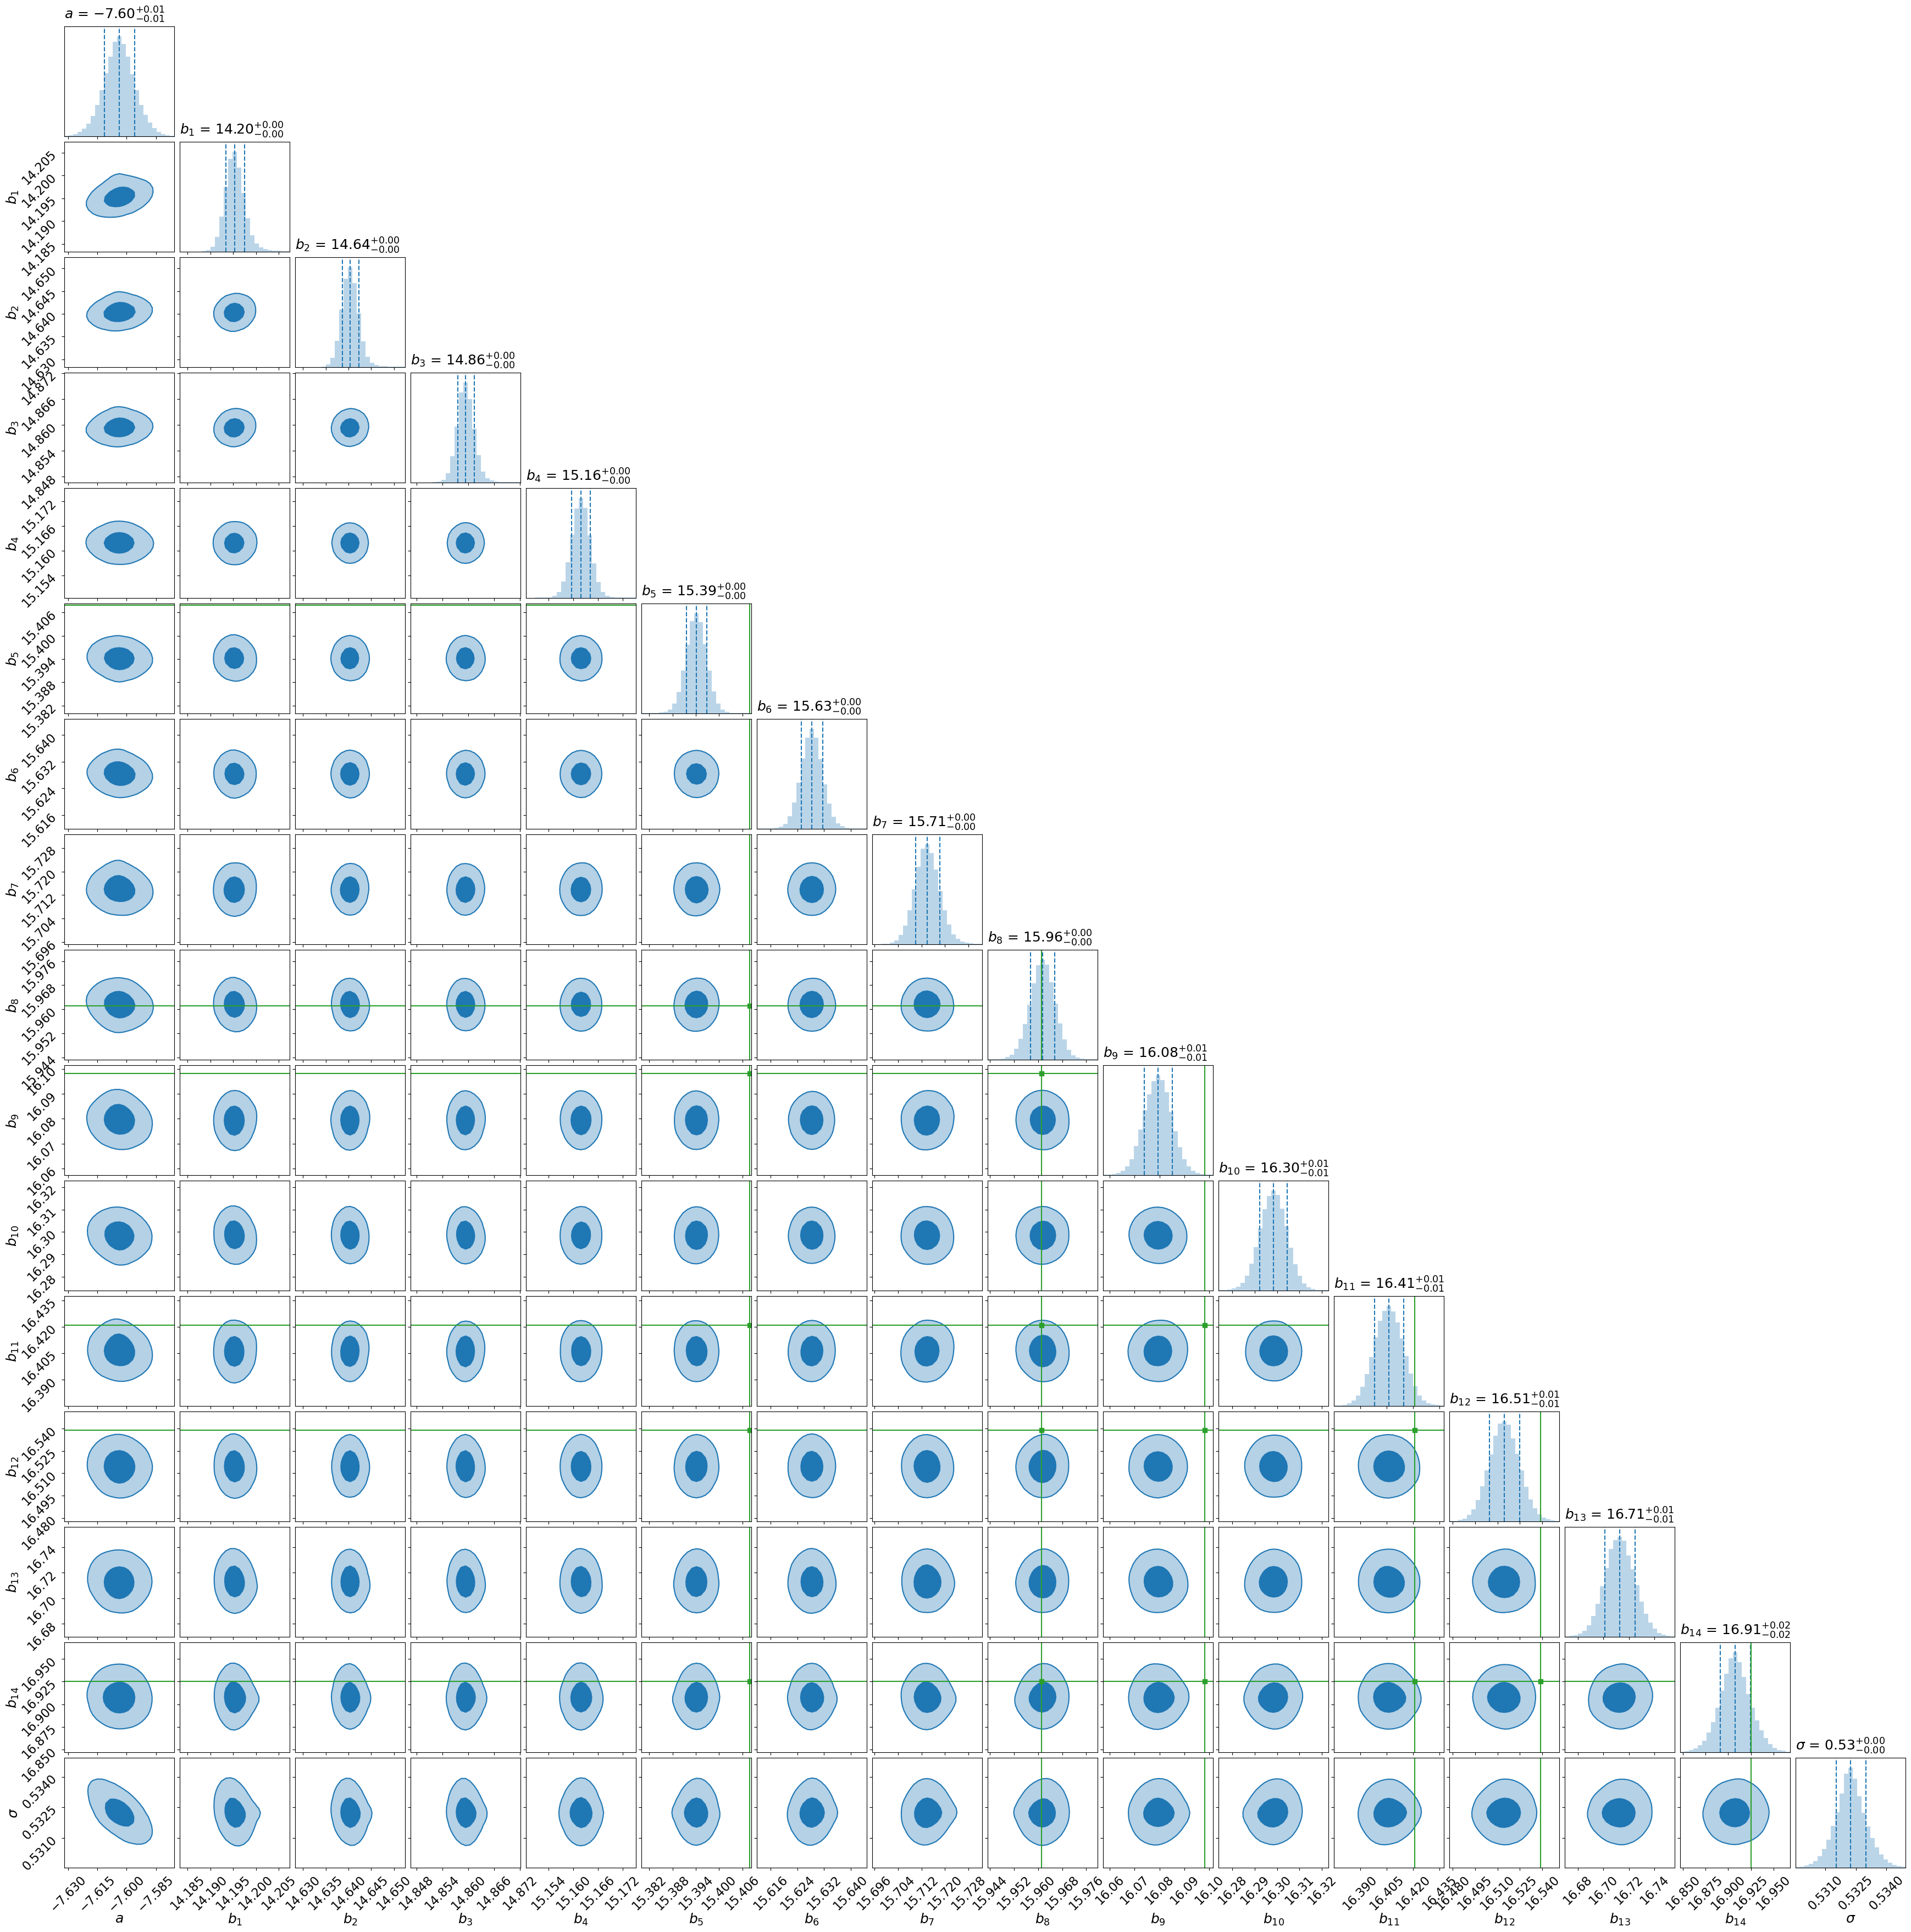

In [39]:
labels  = ['$a$']
labels += [f'$b_{{ {k+1} }}$' for k in np.arange(m)]
labels += [r'$\sigma$']

fig = corner(mcmc_samples.T, bins=25, smooth=1,
             range=limits,
             labels=labels,
             label_kwargs={'fontsize':18},
             labelpad=0.1,
             levels=(1-np.exp(-0.5), 1-np.exp(-2)),
             quantiles=[0.16, 0.5, 0.84],
             color='tab:blue',
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
             plot_datapoints=False,
             fill_contours=True,
             truths=tf_par,
             truth_color='tab:green',
             show_titles=True,
             title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16);

# fig.savefig('tfr_mock_calibration_mcmc.png', dpi=150)

In [40]:
tf_par

array([-7.14473188, 14.42277971, 14.73664217, 14.95751213, 15.19007489,
       15.40782143, 15.60870529, 15.78786127, 15.96115708, 16.09816921,
       16.24871851, 16.4209786 , 16.53873953, 16.76372299, 16.92501236,
        0.44290198])

In [41]:
a_mcmc, b_mcmc, sigma_mcmc

(-7.6036845323790665,
 array([14.19534875, 14.64038545, 14.8593959 , 15.16189504, 15.39415446,
        15.62833554, 15.71399229, 15.96151753, 16.07946958, 16.29840523,
        16.40629261, 16.51464909, 16.71284896, 16.90779529]),
 array([0.53224773]))

#### Quick Check of Many Realizations of the "Calibration" Sample

In [35]:
N = len(logvrot_mock)
Ns = 150

a_real, b_real, sigma_real = [], [], []

for i in tqdm(np.arange(100)):
    idx = np.random.choice(N-1, size=Ns, replace=False)

    logV0_mock = np.median(logvrot_mock)

    logv  = logvrot_mock[idx] - logV0_mock
    dlogv = logvrot_err_mock[idx]
    Mr  = Mr_obs_mock[idx]
    dMr = Mr_obs_err_mock[idx]
    weights = np.ones_like(logv)
    # weights = 1/mock['MAX_VOL_FRAC'].to_numpy()[idx]
    
    mock_dat = np.empty((2, Ns))
    mock_cov = np.empty((2, 2, Ns))
    
    logv, Ns, len(logv)
    
    for k in range(Ns):
        mock_dat[:, k] = np.array([logv[k], Mr[k]])
        mock_cov[:,:,k] = np.array([[dlogv[k]**2, 0.], [0., dMr[k]**2]])
    
    bounds = [[-20, 0]]                    # Bounds on a (slope)
    bounds += [(-40,0)]                    # Bounds on b (intercepts: 0-pt + clusters)
    bounds += [(0,5)]                      # Bounds on sigma
    
    # logging.warning('Fit does not account for volume weights.')
    
    hf = LinFit(mock_dat, mock_cov, weights=weights)
    (a_bf, b_bf), sigma_bf, ll_bf = hf.optimize(bounds, verbose=False)

    a_real.append(a_bf)
    b_real.append(b_bf),
    sigma_real.append(sigma_bf)
    
    # print(f'a = {a_bf:.3f}')
    # print(f'b = {b_bf:.3f}')
    # print(f'sigma = {sigma_bf:.3f}')

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'LinFit' is not defined

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4), tight_layout=True)

ax = axes[0]
ax.hist(a_real, bins=np.arange(-12.5,-2.4,0.4))
ax.axvline(tf_par[0], color='tab:orange', ls='--')
ax.axvline(np.mean(a_real), color='tab:green')
ax.axvline(np.mean(a_real) - np.std(a_real), color='tab:green', ls='--')
ax.axvline(np.mean(a_real) + np.std(a_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{a}}={np.mean(a_real):.2f}\pm{np.std(a_real):.2f}$',
       xlabel=r'slope $a$')

ax = axes[1]
ax.hist(b_real, bins=np.arange(-21.2,-19.95,0.05))
ax.axvline(tf_par[1], color='tab:orange', ls='--')
ax.axvline(np.mean(b_real), color='tab:green')
ax.axvline(np.mean(b_real) - np.std(b_real), color='tab:green', ls='--')
ax.axvline(np.mean(b_real) + np.std(b_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{b}}={np.mean(b_real):.2f}\pm{np.std(b_real):.2f}$',
       xlabel=r'zero point $b_\mathrm{0pt}$')

ax = axes[2]
ax.hist(sigma_real, bins=np.arange(-0.1,1.45,0.05))
ax.axvline(tf_par[2], color='tab:orange', ls='--')
ax.axvline(np.mean(sigma_real), color='tab:green')
ax.axvline(np.mean(sigma_real) - np.std(sigma_real), color='tab:green', ls='--')
ax.axvline(np.mean(sigma_real) + np.std(sigma_real), color='tab:green', ls='--')
ax.set(title=rf'$\hat{{\sigma}}={np.mean(sigma_real):.2f}\pm{np.std(sigma_real):.2f}$',
       xlabel=r'magnitude scatter $\sigma$');

# fig.savefig(f'tfr_fit_param_spread_equal_weight_{os.path.basename(mockfile)[:-9]}.png', dpi=150)
# fig.savefig('tfr_fit_param_spread_error_weighted.png', dpi=150)
# fig.savefig('tfr_fit_param_spread_var_weighted.png', dpi=150)

In [ ]:
tf_par

In [ ]:
a_avg = np.average(a_real)
b_avg = np.average(b_real)
sigma_avg = np.average(sigma_real)
a_avg, b_avg, sigma_avg

In [ ]:
a_mcmc, b_mcmc, sigma_mcmc = a_avg, b_avg, sigma_avg

#### Dwarf Cut

In [42]:
#- Apply dwarf cut using galaxy size
mock['DWARF'] = mock_dwarfs

mock['MAIN'] = mock_main

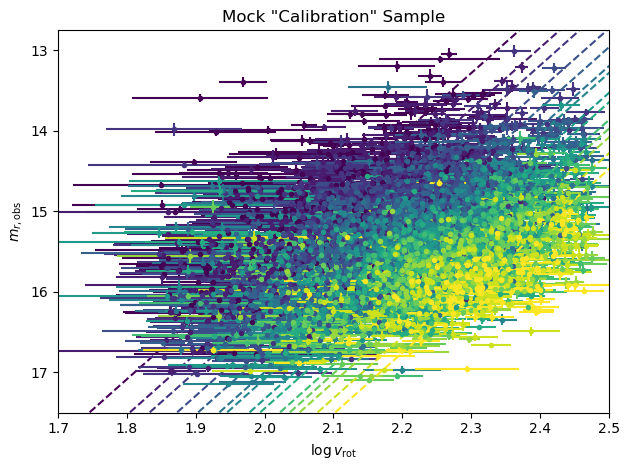

In [44]:
plt.figure(tight_layout=True)

_logv = np.arange(0, 3.1, 0.1)

color = iter(plt.cm.viridis(np.linspace(0,1,m)))
for k in range(m):
    c = next(color)
    plt.errorbar(logv[k] + logV0, mr[k], 
                 xerr=dlogv[k], 
                 yerr=dmr[k], 
                 fmt='.', 
                 c=c)
    plt.plot(_logv, a_mcmc*(_logv - logV0) + b_mcmc[k], color=c, ls='--')

plt.xlim(1.7, 2.5)
plt.ylim(17.5, 12.75)
plt.xlabel(r'$\log{v_\mathrm{rot}}$')
plt.ylabel(r'$m_{r,\mathrm{obs}}$')
plt.title(r'Mock "Calibration" Sample');

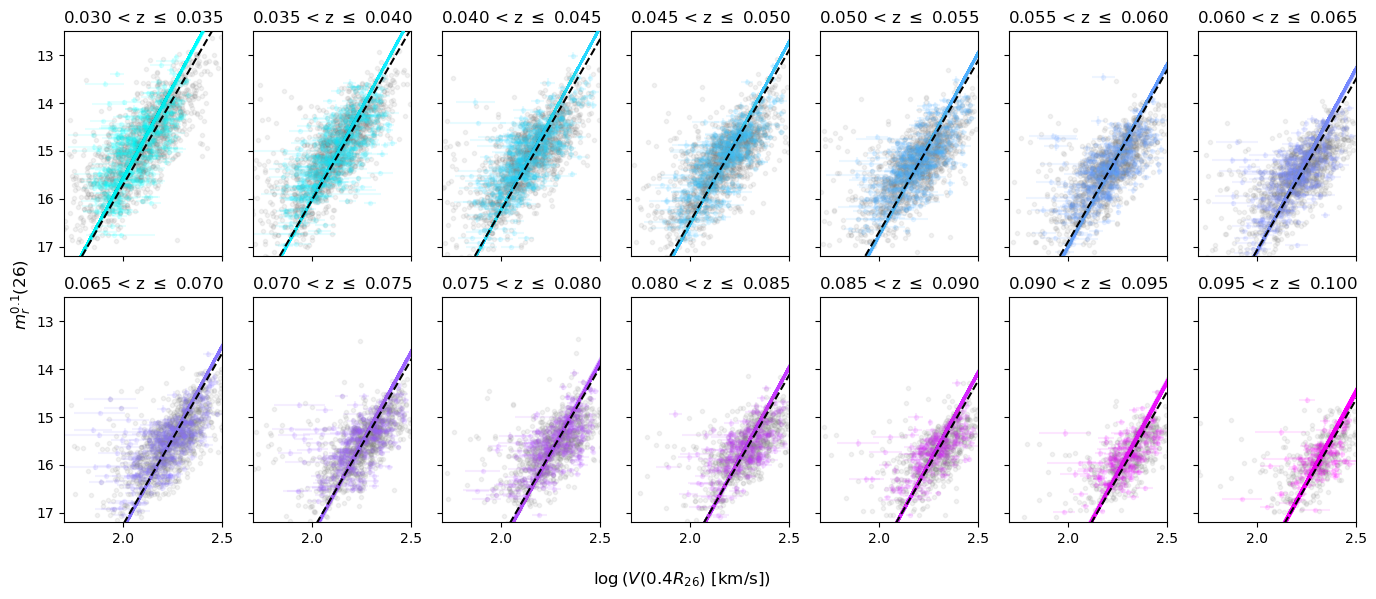

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=7, sharex=True, sharey=True, figsize=(14,6), tight_layout=True)

_logv = np.arange(0, 3.1, 0.5)

color = iter(plt.cm.cool(np.linspace(0,1,m)))
for i in range(m):
    c = next(color)

    row = int(i/7)
    col = i%7

    # Downsampled set of all mock galaxies in the redshift bin
    axes[row,col].plot(mock['LOGVROT_MOCK'][zbin_indices == i + 1][::10], 
                       mock['R_MAG_SB26_CORR'][zbin_indices == i + 1][::10], 
                       '.', c='gray', alpha=0.1)

    # Calibration sample from the mock
    axes[row,col].errorbar(logv[i] + logV0, 
                           mr[i], 
                           xerr=dlogv[i], 
                           yerr=dmr[i], 
                           fmt='.', 
                           c=c, 
                           alpha=0.1)

    # Mock calibration
    for (_a, _b) in mcmc_samples[[0,i+1], ::500].T:
        axes[row,col].plot(_logv, _a*(_logv - logV0) + _b, color=c, alpha=0.05, zorder=10)

    # Data calibration
    axes[row,col].plot(_logv, a*(_logv - logV0) + b[i], 'k--', zorder=20)

    axes[row,col].set(xlim=[1.7, 2.5], ylim=[17.2, 12.5], title=f'{zbins[i]:.3f} < z $\leq$ {zbins[i+1]:.3f}')


fig.supxlabel(r'$\log{(V(0.4R_{26})~[\mathrm{km/s}]}$)')
fig.supylabel(r'$m_r^{0.1} (26)$');

### Compute TFR Distance Modulus

Using the "measured" apparent magnitude and the TFR-predicted absolute magnitude from the "calibration" above, compute the distance modulus:

$$
\mu_\mathrm{TF} =  m_{r,\mathrm{SB_{26}}} - M_{r,\mathrm{TF}}.
$$

Also compute the log distance ratio

$$
\eta = \log{\left(\frac{D_z}{D_\mathrm{TFR}}\right)}
$$

In [47]:
#- Compute TF absolute magnitude and uncertainties using the MCMC from HyperFit.
#  Downsample the MCMC significantly for this quick calculation.

#-------------------------------------------------------------------------------
#- First, calculate the distance modulus for each redshift bin
#-------------------------------------------------------------------------------
# Center redshift values of each bin
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmology.distmod(zc)
#-------------------------------------------------------------------------------
#- Then, convert each redshift bin's y-intercept to an absolute magnitude
#-------------------------------------------------------------------------------
B_mcmc = b_mcmc - mu_zc.value
#-------------------------------------------------------------------------------

B_indices = zbin_indices - 1
# For those galaxies that fall outside the calibration range, assign them to the closest bin
B_indices[zbin_indices == 0] = 0
B_indices[zbin_indices == len(zbins)] = len(zbins) - 2

Mr_TF = a_mcmc * (mock['LOGVROT_MOCK'] - logV0) + B_mcmc[B_indices]

# This method takes up too much memory, and the uncertainties on the parameters 
# are subdominant to the scatter and velocity uncertainties anyway
# a_sampled, B_sampled = mcmc_samples[0][::500], mcmc_samples[B_indices][::500] - mu_zc[B_indices, np.newaxis].value
# Mr_TF_err = np.std(a_sampled * (logvrot_mock[:, np.newaxis] - logV0_mock) + B_sampled, axis=1)
rng = np.random.default_rng()
Mr_TF_err = np.zeros(len(mock))
for i in range(len(mock)):
    logv_random = rng.normal(logvrot_mock[i], 0.434*logvrot_err_mock[i], size=1000)
    Mr_stat = a_mcmc*(logv_random - logV0) + B_mcmc[B_indices[i]]
    Mr_TF_err[i] = np.sqrt(np.nanstd(Mr_stat)**2 + sigma_mcmc**2)

mu_TF = mock['R_MAG_SB26_CORR'] - Mr_TF
mu_TF_err = np.sqrt(mock['R_ABSMAG_SB26_ERR_MOCK']**2 + Mr_TF_err**2)

mu_zcmb = cosmology.distmod(mock['zobs']).to_value('mag')
mu_zcos = cosmology.distmod(mock['zcos']).to_value('mag')

eta_true = 0.2 * (mu_zcmb - mu_zcos)
eta_mock = 0.2 * (mu_zcmb - mu_TF)
eta_err_mock = 0.2 * mu_TF_err

In [48]:
fig, axes = plt.subplots(1,3, figsize=(15, 5), tight_layout=True, sharex=True, sharey=True)


# axes[0].plot(mu_zcmb[~mock_main], mu_zcos[~mock_main], '.', c='gray', alpha=0.1, zorder=0)
# axes[0].plot(mu_zcmb[mock_main], mu_zcos[mock_main], '.', alpha=0.1, zorder=1)
axes[0].hexbin(mu_zcmb[~mock_main], 
               mu_zcos[~mock_main], 
               cmap='bone', 
               mincnt=1, 
               vmin=1, 
               vmax=1000, 
               gridsize=(100,50), 
               extent=(25, 41, 25, 41)
              )
axes[0].hexbin(mu_zcmb[mock_main], 
               mu_zcos[mock_main], 
               cmap='plasma', 
               mincnt=1, 
               vmin=1, 
               vmax=1000, 
               gridsize=(50,50), 
               extent=(25, 41, 25, 41)
              )
axes[0].plot([22, 42], [22, 42], '--', c='gray')
axes[0].grid(ls=':')
axes[0].set(#xlim=[30, 38], 
            #ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{cos (true)}$', 
            xlabel=r'$\mu_\mathrm{CMB}$')


# axes[1].plot(mu_zcmb[~mock_main], mu_TF[~mock_main], '.', c='gray', alpha=0.1, zorder=0)
# axes[1].plot(mu_zcmb[mock_main], mu_TF[mock_main], '.', alpha=0.1, zorder=1)
axes[1].hexbin(mu_zcmb[~mock_main], 
               mu_TF[~mock_main], 
               cmap='bone', 
               mincnt=1, 
               vmin=1, 
               vmax=100, 
               gridsize=(100,50), 
               extent=(25, 41, 25, 41)
              )
axes[1].hexbin(mu_zcmb[mock_main], 
               mu_TF[mock_main], 
               cmap='plasma', 
               mincnt=1, 
               vmin=1, 
               vmax=1000, 
               gridsize=(50,50), 
               extent=(25, 41, 25, 41)
              )
axes[1].plot([22, 42], [22, 42], '--', c='gray')
axes[1].grid(ls=':')
axes[1].set(#xlim=[30, 38], 
            #ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{TF}$', 
            xlabel=r'$\mu_\mathrm{CMB}$')

# axes[2].plot(mu_zcos[~mock_main], mu_TF[~mock_main], '.', c='gray', alpha=0.1, zorder=0)
# axes[2].plot(mu_zcos[mock_main], mu_TF[mock_main], '.', alpha=0.1, zorder=1)
axes[2].hexbin(mu_zcos[~mock_main], 
               mu_TF[~mock_main], 
               cmap='bone', 
               mincnt=1, 
               vmin=1, 
               vmax=100, 
               gridsize=(100,50), 
               extent=(25, 41, 25, 41)
              )
axes[2].hexbin(mu_zcos[mock_main], 
               mu_TF[mock_main], 
               cmap='plasma', 
               mincnt=1, 
               vmin=1, 
               vmax=1000, 
               gridsize=(50,50), 
               extent=(25, 41, 25, 41)
              )
axes[2].plot([22, 42], [22, 42], '--', c='gray')
axes[2].grid(ls=':')
axes[2].set(xlim=[30, 38], 
            ylim=[25, 41], 
            ylabel=r'$\mu_\mathrm{TF}$', 
            xlabel=r'$\mu_\mathrm{cos (true)}$', 
            title='These should be equal');

/global/u1/k/kadglass/DESI_SGA/TF/help_functions.py:68: RuntimeWarning: invalid value encountered in true_divide
  e = np.sqrt((mean2 - mean**2) / (N - 1))


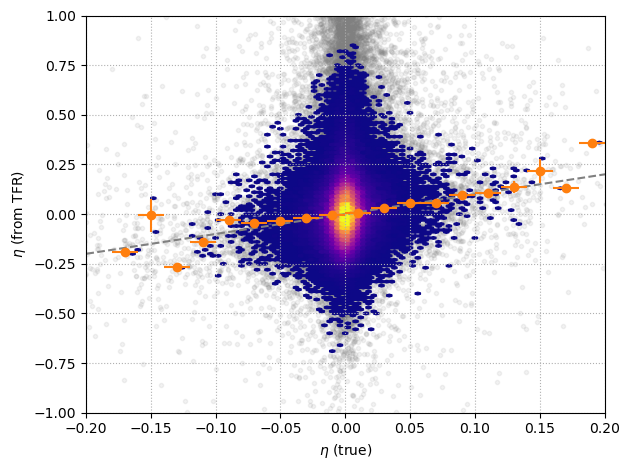

In [49]:
plt.figure(tight_layout=True)

plt.plot(eta_true[~mock_main], eta_mock[~mock_main], '.', c='gray', alpha=0.1, zorder=0)
# plt.plot(eta_true[mock_main], eta_mock[mock_main], '.', alpha=0.1, zorder=1)
plt.hexbin(eta_true[mock_main], 
           eta_mock[mock_main], 
           cmap='plasma', 
           mincnt=1, 
           vmin=1, 
           vmax=1000, 
           gridsize=(100,100), 
           extent=(-0.2, 0.2, -1, 1))

plt.plot([-5, 2], [-5, 2], '--', c='gray')

eta_bins = np.arange(-0.5, 0.3, 0.02)
d_eta = 0.5*np.diff(eta_bins)
eta_c = 0.5*(eta_bins[1:] + eta_bins[:-1])

_, eta_avg, eta_std = profile_histogram(eta_true[mock_main], eta_mock[mock_main], eta_bins, stat='median')
plt.errorbar(eta_c, eta_avg, xerr=d_eta, yerr=eta_std, fmt='o', color='tab:orange', zorder=2)

plt.grid(ls=':')

plt.xlim([-0.2, 0.2])
plt.ylim([-1, 1])

plt.xlabel(r'$\eta$ (true)')
plt.ylabel(r'$\eta$ (from TFR)');

/global/u1/k/kadglass/DESI_SGA/TF/help_functions.py:62: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/global/u1/k/kadglass/DESI_SGA/TF/help_functions.py:63: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


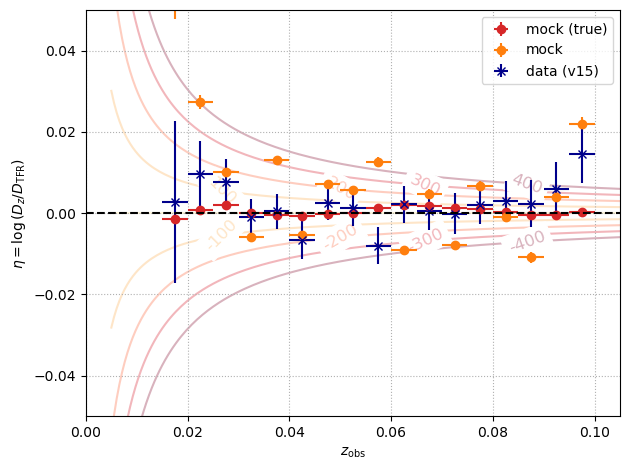

In [50]:
fig = plt.figure(tight_layout=True)

_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])


plt.grid(ls=':')

# True mock
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], 
                                        eta_true[mock_main], 
                                        _zbins)
plt.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:red', label='mock (true)')

# Mock
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], 
                                        eta_mock[mock_main], 
                                        _zbins, 
                                        weights=eta_err_mock[mock_main]**-2, 
                                        weighted=True)
plt.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='mock')

# Data
_, data_eta_avg, data_eta_std = profile_histogram(tfrcat['Z_DESI'][tfrcat['MAIN']], 
                                                  tfrcat['LOGDIST'][tfrcat['MAIN']], 
                                                  _zbins, 
                                                  weights=tfrcat['LOGDIST_ERR'][tfrcat['MAIN']]**-2, 
                                                  weighted=True)
plt.errorbar(zc, data_eta_avg, xerr=dz, yerr=data_eta_std, fmt='x', color='darkblue', label=f'data ({tfr_version})')

#-------------------------------------------------------------------------------
# PV lines (code taken from Cullen)
#-------------------------------------------------------------------------------
velarray = np.arange(-400, 401, 100)
zarray = np.linspace(0.005, 0.11, 200)

dzarray = cosmology.comoving_distance(zarray).value
dharray = cosmology.comoving_distance(np.outer(1.0/(1.0 + velarray/LightSpeed), 
    								  (1.0 + zarray)) - 1.0).value
deltamarray = np.log10(dzarray/dharray)

rotation = [20.0, 25.0, 30.0, 45.0, 0.0, -45.0, -30.0, -25.0, -20.0]
labels = ["-400", "-300", "-200", "-100", "0", "100", "200", "300", "400"]
xcoord = np.array([26000.0, 20000.0, 15000.0, 8000.0, -1000.0, 8000.0, 15000.0, 20000.0, 26000.0])
coord = np.searchsorted(zarray, xcoord/LightSpeed)
ycoord = np.array([deltamarray[i,j] for i, j in enumerate(coord)])

colors = 0.8*np.fabs(velarray)/np.amax(np.fabs(velarray)) + 0.2

for v in range(len(velarray)):
    c = plt.cm.YlOrRd(colors[v])

    plt.plot(zarray, deltamarray[v,:], 
             color=c, 
             linestyle='-', 
             alpha=0.3, 
             zorder=0)

    if (v != 4):
        plt.text(xcoord[v]/LightSpeed, ycoord[v], 
                 labels[v], 
                 color=c, 
                 fontsize=12, 
                 rotation=rotation[v], 
                 ha="center", 
                 va="center", 
                 bbox=dict(boxstyle="square", ec="w", fc="w"), 
                 zorder=1, 
                 alpha=0.3)

# Line at eta = 0
plt.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)
#-------------------------------------------------------------------------------

plt.legend()

plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel(r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')

plt.xlim(0,0.105)
plt.ylim(-0.05, 0.05);

# fig.savefig('tfr_mock_eta.png', dpi=150);

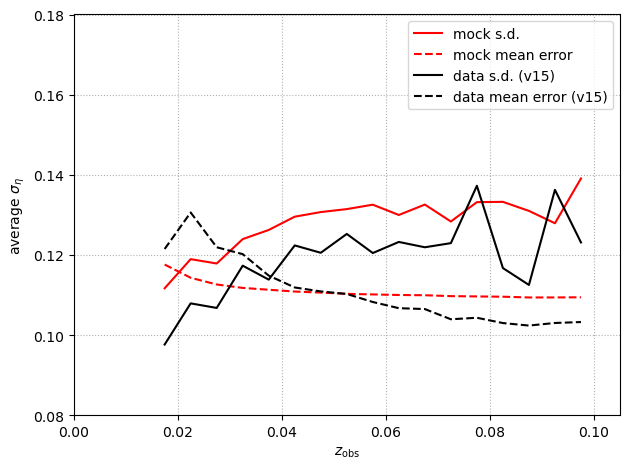

In [51]:
# In each redshift bin, compute the standard deviation of the log-distance ratios
# And compare this to the average value of the uncertainty in the log-distance ratio in each bin
# Do this for both mocks and data

plt.figure(tight_layout=True)

plt.grid(ls=':')

_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

# Mock standard deviation in each bin
_, eta_std,_ = profile_histogram(mock['zobs'][mock_main], 
                                 eta_mock[mock_main], 
                                 _zbins, 
                                 stat='std')
plt.plot(zc, eta_std, 'r', label='mock s.d.')

# Mock average error
_, eta_err_avg,_ = profile_histogram(mock['zobs'][mock_main], 
                                     eta_err_mock[mock_main], 
                                     _zbins)
plt.plot(zc, eta_err_avg, 'r--', label='mock mean error')

# Data standard deviation in each bin
_, data_eta_std,_ = profile_histogram(tfrcat['Z_DESI'][tfrcat['MAIN']], 
                                      tfrcat['LOGDIST'][tfrcat['MAIN']], 
                                      _zbins, 
                                      stat='std')
plt.plot(zc, data_eta_std, 'k', label=f'data s.d. ({tfr_version})')

# Data average error
_, data_eta_err_avg,_ = profile_histogram(tfrcat['Z_DESI'][tfrcat['MAIN']], 
                                          tfrcat['LOGDIST_ERR'][tfrcat['MAIN']], 
                                          _zbins)
plt.plot(zc, data_eta_err_avg, 'k--', label=f'data mean error ({tfr_version})')


plt.legend()

plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel(r'average $\sigma_\eta$')

plt.xlim(0,0.105)
plt.ylim(0.08, 0.18);

## Redshift distribution

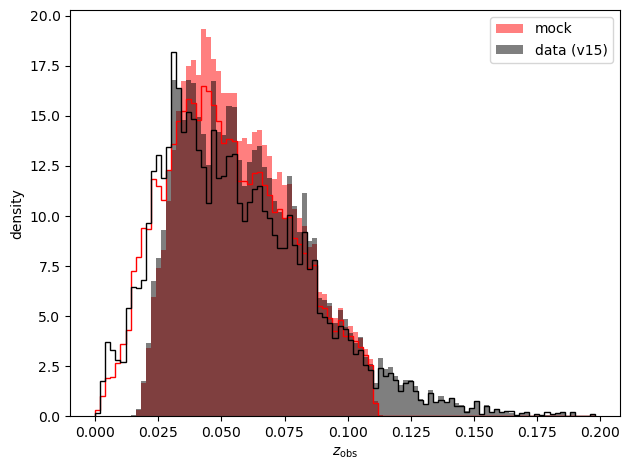

In [52]:
plt.figure(tight_layout=True)

_zbins = np.arange(0, 0.2, 0.002)

# Mocks
plt.hist(mock['zobs'], bins=_zbins, density=True, color='r', histtype='step')
plt.hist(mock['zobs'][mock_main], bins=_zbins, density=True, color='r', alpha=0.5, label='mock')

# Data
plt.hist(tfrcat['Z_DESI'], bins=_zbins, density=True, color='k', histtype='step')
plt.hist(tfrcat['Z_DESI'][tfrcat['MAIN']], bins=_zbins, density=True, color='k', alpha=0.5, label=f'data ({tfr_version})')

plt.legend()

plt.xlabel(r'$z_\mathrm{obs}$')
plt.ylabel('density');

/tmp/ipykernel_1832447/497888321.py:1: RuntimeWarning: invalid value encountered in log10
  logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)


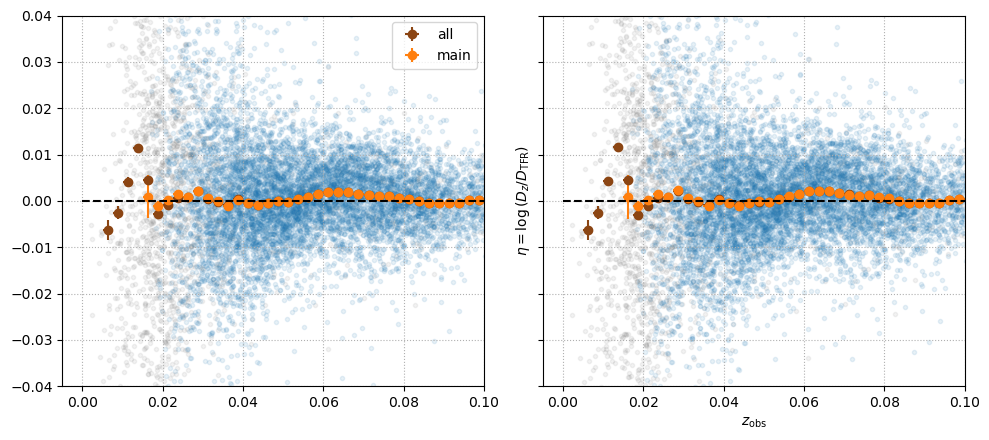

In [79]:
logdist_true = np.log10(cosmology.comoving_distance(mock['zobs'].to_numpy()).value/cosmology.comoving_distance(mock['zcos'].to_numpy()).value)

fig, axes = plt.subplots(1,2, figsize=(10,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.scatter(mock['zobs'][~mock_main][::20], logdist_true[~mock_main][::20], 
           marker='.', 
           c='gray',
           alpha=0.1)
ax.scatter(mock['zobs'][mock_main][::20], logdist_true[mock_main][::20], 
           marker='.', alpha=0.1)

ax = axes[1]
ax.scatter(mock['zobs'][~mock_main][::20], eta_true[~mock_main][::20], 
           marker='.', 
           c='gray',
           alpha=0.1)
ax.scatter(mock['zobs'][mock_main][::20], eta_true[mock_main][::20], 
           marker='.', alpha=0.1)

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], logdist_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='saddlebrown', label='all')
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], logdist_true[mock_main], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='main')

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=10)
ax.grid(ls=':')

ax.legend()

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='saddlebrown', label='all')
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_true[mock_main], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='main')

ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed', zorder=10)

ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       # ylim=(-1,1),
       ylim=(-0.04, 0.04),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

/tmp/ipykernel_1832447/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_1832447/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


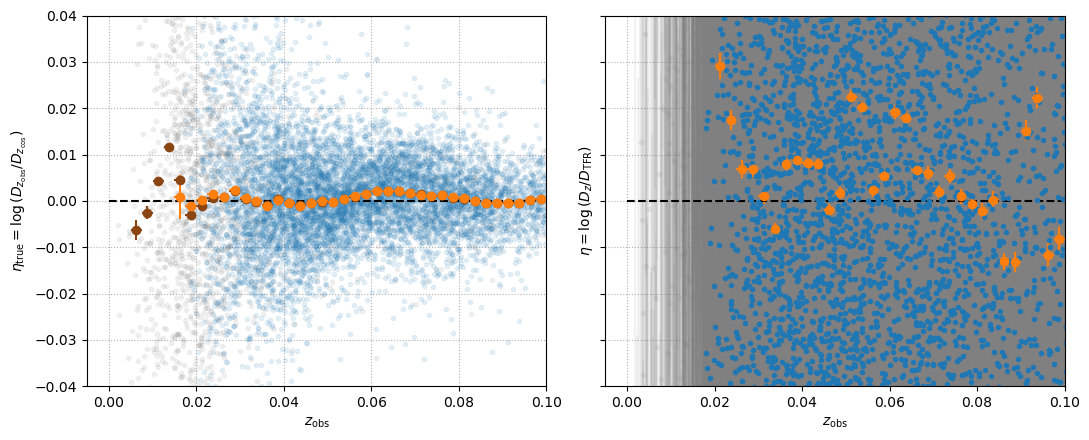

In [80]:
fig, axes = plt.subplots(1,2, figsize=(11,4.5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]
ax.plot(mock['zobs'][~mock_main][::20], eta_true[~mock_main][::20], '.', alpha=0.1, c='gray')
ax.plot(mock['zobs'][mock_main][::20], eta_true[mock_main][::20], '.', alpha=0.1)

ax = axes[1]
ax.errorbar(mock['zobs'][~mock_main][::20], eta_mock[~mock_main][::20], 
            yerr=eta_err_mock[~mock_main][::20], 
            fmt='.', color='gray', alpha=0.1)
ax.errorbar(mock['zobs'][mock_main][::20], eta_mock[mock_main][::20], 
            yerr=eta_err_mock[mock_main][::20], 
            fmt='.', ecolor='gray')

zbins = np.arange(0, 0.1025, 0.0025)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

ax = axes[0]
_, eta_avg, eta_std = profile_histogram(mock['zobs'], eta_true, zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='saddlebrown', label='all')
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_true[mock_main], zbins)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange', label='main')
ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       # xlim=(-0.005,0.1),
       # ylim=(-1,1),
       ylabel=r'$\eta_\mathrm{true} = \log{(D_{z_\mathrm{obs}} / D_{z_\mathrm{cos}})}$')
ax.grid(ls=':')

ax = axes[1]
_, eta_avg, eta_std = profile_histogram(mock['zobs'][mock_main], eta_mock[mock_main], 
                                        zbins, weights=eta_err_mock[mock_main]**-2, weighted=True)
ax.errorbar(zc, eta_avg, xerr=dz, yerr=eta_std, fmt='o', color='tab:orange')
ax.hlines(0, zbins[0], zbins[-1], colors='k', linestyles='dashed')
ax.set(xlabel=r'$z_\mathrm{obs}$',
       xlim=(-0.005,0.1),
       # ylim=(-1,1),
       ylim=(-0.04, 0.04),
       ylabel=r'$\eta = \log{(D_z / D_\mathrm{TFR})}$')
ax.grid(ls=':');

# fig.savefig('tfr_mock_eta_true_mock.png', dpi=150);

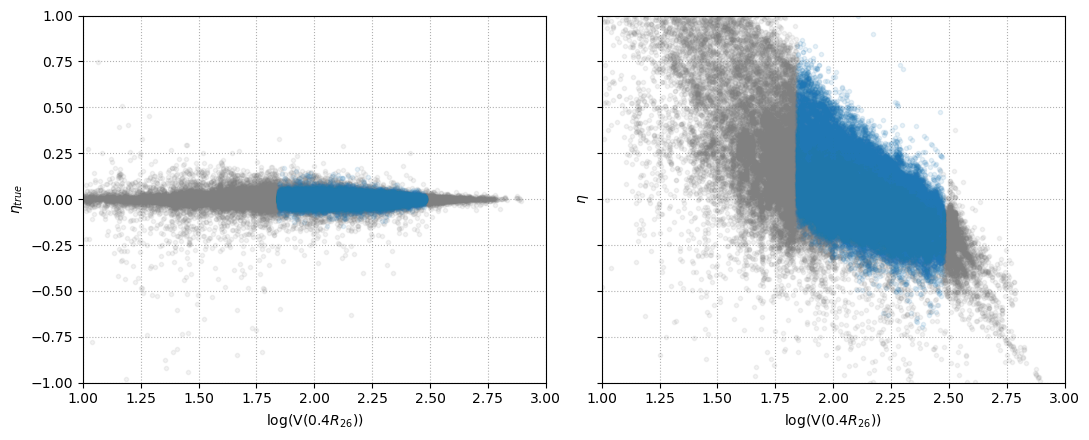

In [83]:
fig, axes = plt.subplots(1,2, figsize=(11,4.5), tight_layout=True, sharex=True, sharey=True)

# Truth
ax = axes[0]
ax.plot(logvrot_mock[~mock_main], eta_true[~mock_main], '.', alpha=0.1, c='gray')
ax.plot(logvrot_mock[mock_main], eta_true[mock_main], '.', alpha=0.1)

ax.grid(ls=':')

ax.set(xlabel='log(V(0.4$R_{26}$))', 
       ylabel='$\eta_{true}$', 
       ylim=(-1, 1), 
       xlim=(1,3))


# Mock (generated)
ax = axes[1]
ax.plot(logvrot_mock[~mock_main], eta_mock[~mock_main], '.', alpha=0.1, c='gray')
ax.plot(logvrot_mock[mock_main], eta_mock[mock_main], '.', alpha=0.1)

ax.grid(ls=':')

ax.set(xlabel='log(V(0.4$R_{26}$))', 
       ylabel='$\eta$');

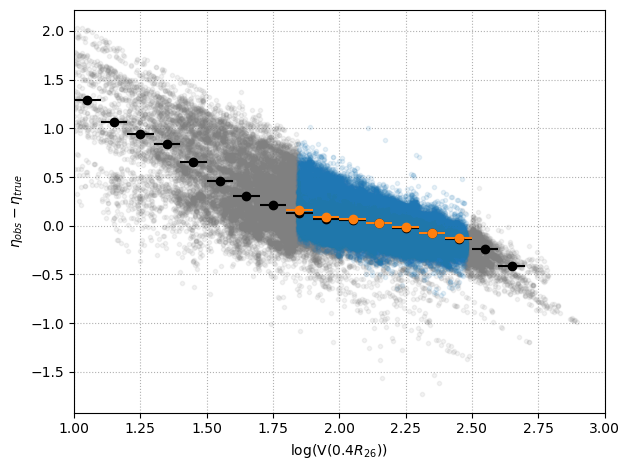

In [85]:
logv_bins = np.arange(1, 2.75, 0.1)
dv = 0.5*np.diff(logv_bins)
vc = 0.5*(logv_bins[1:] + logv_bins[:-1])

plt.figure(tight_layout=True)

plt.plot(logvrot_mock[~mock_main], 
         eta_mock[~mock_main] - eta_true[~mock_main], 
         '.', c='gray', alpha=0.1)

plt.plot(logvrot_mock[mock_main], 
         eta_mock[mock_main] - eta_true[mock_main], 
         '.', c='tab:blue', alpha=0.1)

_, dn_avg, dn_std = profile_histogram(logvrot_mock, eta_mock - eta_true, logv_bins, median=True)
plt.errorbar(vc, dn_avg, xerr=dv, yerr=dn_std, fmt='o', color='black')

_, dn_avg, dn_std = profile_histogram(logvrot_mock[mock_main], 
                                      eta_mock[mock_main] - eta_true[mock_main], 
                                      logv_bins, 
                                      median=True)
plt.errorbar(vc, dn_avg, xerr=dv, yerr=dn_std, fmt='o', color='tab:orange')

plt.grid(ls=':')

plt.xlim((1,3))

plt.xlabel('log(V(0.4$R_{26}$))')
plt.ylabel('$\eta_{obs} - \eta_{true}$');

## Correlation with magnitude

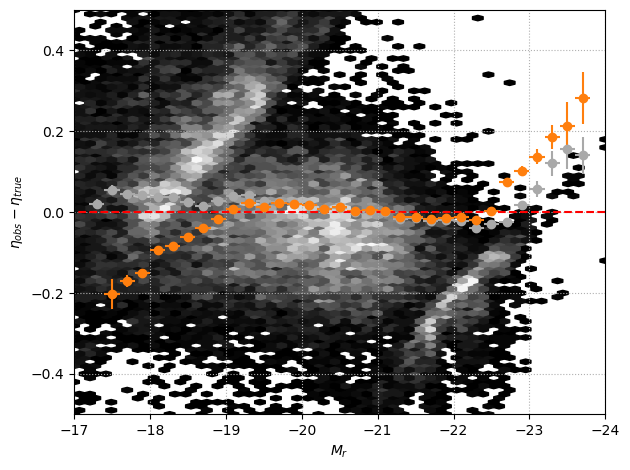

In [76]:
Mr_bins = np.arange(-24, -17, 0.2)
dMr = 0.5*np.diff(Mr_bins)
Mrc = 0.5*(Mr_bins[1:] + Mr_bins[:-1])

plt.figure(tight_layout=True)

plt.hexbin(mock['R_ABSMAG_SB26_MOCK'][~mock_main], 
           eta_mock[~mock_main] - eta_true[~mock_main], 
           cmap='Greys_r', 
           vmin=1, 
           vmax=50, 
           mincnt=1, 
           gridsize=(50, 50), 
           extent=(-24, -17, -0.5, 0.5))

# plt.hexbin(mock['R_ABSMAG_SB26_MOCK'][mock_main], 
#            eta_mock[mock_main] - eta_true[mock_main], 
#            cmap='viridis', 
#            vmin=1, 
#            vmax=400, 
#            mincnt=1, 
#            gridsize=(50, 50), 
#            extent=(-24, -17, -0.5, 0.5))

_, dn_avg, dn_std = profile_histogram(mock['R_ABSMAG_SB26_MOCK'], 
                                      eta_mock - eta_true, 
                                      Mr_bins, stat='median')
plt.errorbar(Mrc, dn_avg, xerr=dMr, yerr=dn_std, fmt='o', color='darkgrey')

_, dn_avg, dn_std = profile_histogram(mock['R_ABSMAG_SB26_MOCK'][mock_main], 
                                      eta_mock[mock_main] - eta_true[mock_main], 
                                      Mr_bins, 
                                      stat='median')
plt.errorbar(Mrc, dn_avg, xerr=dMr, yerr=dn_std, fmt='o', color='tab:orange')

plt.hlines(0, -24, -17, linestyles='dashed', colors='r')

plt.grid(ls=':')

plt.xlim((-17,-24))
plt.ylim(-0.5, 0.5)

plt.xlabel('$M_r$')
plt.ylabel('$\eta_{obs} - \eta_{true}$');

## Correlation with redshift

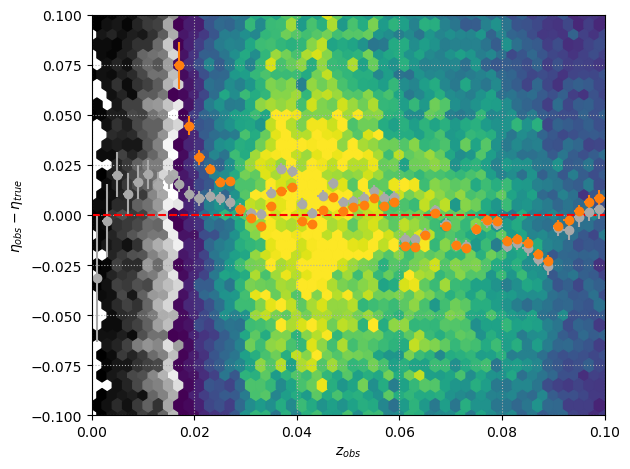

In [92]:
_zbins = np.arange(0, 0.2, 0.002)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

plt.figure(tight_layout=True)

plt.hexbin(mock['zobs'][~mock_main], 
           eta_mock[~mock_main] - eta_true[~mock_main], 
           cmap='Greys_r', 
           vmin=1, 
           vmax=50, 
           mincnt=1, 
           gridsize=(50, 100), 
           extent=(0, 0.1, -0.5, 0.5))

plt.hexbin(mock['zobs'][mock_main], 
           eta_mock[mock_main] - eta_true[mock_main], 
           cmap='viridis', 
           vmin=1, 
           vmax=100, 
           mincnt=1, 
           gridsize=(50, 100), 
           extent=(0, 0.1, -0.5, 0.5))

_, dn_avg, dn_std = profile_histogram(mock['zobs'], 
                                      eta_mock - eta_true, 
                                      _zbins, stat='median')
plt.errorbar(zc, dn_avg, xerr=dz, yerr=dn_std, fmt='o', color='darkgrey')

_, dn_avg, dn_std = profile_histogram(mock['zobs'][mock_main], 
                                      eta_mock[mock_main] - eta_true[mock_main], 
                                      _zbins, 
                                      stat='median')
plt.errorbar(zc, dn_avg, xerr=dz, yerr=dn_std, fmt='o', color='tab:orange')

plt.hlines(0, 0, 0.1, linestyles='dashed', colors='r')

plt.grid(ls=':')

plt.xlim(0, 0.1)
plt.ylim(-0.1, 0.1)

plt.xlabel('$z_{obs}$')
plt.ylabel('$\eta_{obs} - \eta_{true}$');

## Write Output to FITS

In [34]:
outfile = os.path.join('/global/cfs/cdirs/desi/science/td/pv/mocks/TF_mocks/fullmocks/v0.5',
                       os.path.basename(mockfile).replace('.dat.hdf5', '.fits').replace('BGS_PV', 'TF'))

hdr = fits.Header(dict(NTF=len(mock),
                       a=a_mcmc,
                       b=b_mcmc,
                       sigma=sigma_mcmc,
                       cov_aa=cov_mcmc[0][0],
                       cov_ab=cov_mcmc[0][1],
                       cov_as=cov_mcmc[0][2],
                       cov_bb=cov_mcmc[1][1],
                       cov_bs=cov_mcmc[1][2],
                       cov_ss=cov_mcmc[2][2]))

col01 = fits.Column(name='RA',            format='D', array=mock['ra'].to_numpy())
col02 = fits.Column(name='DEC',           format='D', array=mock['dec'].to_numpy())
col03 = fits.Column(name='ZOBS',          format='D', array=mock['zobs'].to_numpy())
col04 = fits.Column(name='ZCOS',          format='D', array=mock['zcos'].to_numpy())
col05 = fits.Column(name='vx',            format='D', array=mock['vx'].to_numpy())
col06 = fits.Column(name='vy',            format='D', array=mock['vy'].to_numpy())
col07 = fits.Column(name='vz',            format='D', array=mock['vz'].to_numpy())
col08 = fits.Column(name='DWARF',         format='L', array=mock['DWARF'].to_numpy())
col09 = fits.Column(name='LOGVROT',       format='D', array=mock['LOGVROT_MOCK'].to_numpy())
col10 = fits.Column(name='R_ABSMAG_SB26', format='D', array=mock['R_ABSMAG_SB26_MOCK'].to_numpy())
col11 = fits.Column(name='LOGDIST_TRUE',  format='D', array=eta_true)
col12 = fits.Column(name='LOGDIST',       format='D', array=eta_mock.to_numpy())
col13 = fits.Column(name='LOGDIST_ERR',   format='D', array=eta_err_mock.to_numpy())

hdulist = fits.BinTableHDU.from_columns([col01, col02, col03, col04, col05,
                                         col06, col07, col08, col09, col10,
                                         col11, col12, col13], header=hdr)
hdulist.writeto(outfile, overwrite=True)

shutil.chown(outfile, group='desi')